# Experiment 1

- Rank metrics for each model for store & upc. The metrics are the average over all folds. (total of 52 weeks)
- Plots over time
- 

In [5]:
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
import yaml
from tqdm import tqdm 
from glob import glob

# Get the current project path (where you open the notebook)
# and go up two levels to get the project path
current_dir = Path.cwd()
proj_path = current_dir.parent.parent

# make the code in src available to import in this notebook
import sys
sys.path.append(os.path.join(proj_path,'src'))

from metrics import *
from utils import *

# Catalog contains all the paths related to datasets
with open(os.path.join(proj_path, 'conf/catalog.yml'), "r") as f:
    catalog = yaml.safe_load(f)['breakfast']
    
# Params contains all of the dataset creation parameters and model parameters
with open(os.path.join(proj_path, 'conf/params.yml'), "r") as f:
    params = yaml.safe_load(f)

In [6]:
stores = list(params['breakfast']['dataset']['store_ids'].keys())
upcs = list(params['breakfast']['dataset']['upc_ids'].keys())

full_search = list(itertools.product(stores, upcs))

date_ranges = make_dates(params['breakfast']['experiment_dates'])['test_end']

In [7]:
# Select a paid of store and upc:
# Currently only has 3 to 7.
store, upc = full_search[0]

In [15]:
# Aggregate all predictions of each model for exp1

all_stores_upc = {}
for store, upc in full_search:
    xgb_exp1 =[]
    lstm_exp1 =[]
    sarima_exp1 =[]
    prophet_exp1 =[]
    
    for fpath in glob(str(proj_path / f'data/04_results/*')):
        if 'olist' in fpath:
            pass
        else:
            xgb_exp1.append(pd.read_csv(os.path.join(fpath,f'xgb_exp1_{store}_{upc}.csv')))
            lstm_exp1.append(pd.read_csv(os.path.join(fpath,f'lstm_exp1_{store}_{upc}.csv')))
            sarima_exp1.append(pd.read_csv(os.path.join(fpath,f'sarima_{store}_{upc}.csv')))
            prophet_exp1.append(pd.read_csv(os.path.join(fpath,f'prophet_{store}_{upc}.csv')))

    xgb_exp1 = pd.concat(xgb_exp1).reset_index(drop=True)
    lstm_exp1 = pd.concat(lstm_exp1).reset_index(drop=True)
    sarima_exp1 = pd.concat(sarima_exp1).reset_index(drop=True)
    prophet_exp1 = pd.concat(prophet_exp1).reset_index(drop=True)
    
    # clean up each experiments and standardize their outputs here
    xgb_exp1 = xgb_exp1.rename(columns={'test_predictions':'y_pred_xgb',
                                        'WEEK_END_DATE':'dates'})[['dates','y_pred_xgb','y_true']]
    lstm_exp1['dates'] = xgb_exp1['dates']
    lstm_exp1.drop(columns='Unnamed: 0',inplace=True)
    lstm_exp1 = lstm_exp1.rename(columns={'y_pred':'y_pred_lstm'})
    sarima_exp1.drop(columns='Unnamed: 0',inplace=True)
    # Choose next day VS long term here
    sarima_exp1 = sarima_exp1.rename(columns={'y_pred_nd':'y_pred_sarima'})
    prophet_exp1.drop(columns='Unnamed: 0',inplace=True)
    prophet_exp1 = prophet_exp1.rename(columns={'ds':'dates','y':'y_true','preds':'y_pred_prophet'})
    
    xgb_exp1.set_index('dates', inplace=True)
    lstm_exp1.set_index('dates', inplace=True)
    sarima_exp1.set_index('dates', inplace=True)
    prophet_exp1.set_index('dates', inplace=True)

    df = pd.concat([xgb_exp1[['y_true','y_pred_xgb']],
               sarima_exp1['y_pred_sarima'],
               lstm_exp1['y_pred_lstm'],
               prophet_exp1['y_pred_prophet']],axis=1)
    all_stores_upc[f'{store}_{upc}'] = df

In [16]:
def get_min_max(df, date_ranges):
    
    _metrics_xgb = []
    _metrics_sarima = []
    _metrics_lstm = []
    _metrics_prophet = []
    
    for window in date_ranges.itertuples():
        # Filter period
        temp = df[(pd.to_datetime(df.index) >= window[5]) & 
                  (pd.to_datetime(df.index) <= window[6])]
        _metrics_xgb.append(get_metrics(temp['y_true'],temp['y_pred_xgb']))
        _metrics_sarima.append(get_metrics(temp['y_true'],temp['y_pred_sarima']))
        _metrics_lstm.append(get_metrics(temp['y_true'],temp['y_pred_lstm']))
        _metrics_prophet.append(get_metrics(temp['y_true'],temp['y_pred_prophet']))
    
    # Get the min and max for each metric for each model
    return pd.DataFrame({'model':['sarima','prophet','xgb','lstm'],
                      'min_wape':[pd.DataFrame(_metrics_sarima)['wape'].min(),
                                 pd.DataFrame(_metrics_prophet)['wape'].min(),
                                 pd.DataFrame(_metrics_xgb)['wape'].min(),
                                 pd.DataFrame(_metrics_lstm)['wape'].min()],
                      'min_rmse':[pd.DataFrame(_metrics_sarima)['rmse'].min(),
                                 pd.DataFrame(_metrics_prophet)['rmse'].min(),
                                 pd.DataFrame(_metrics_xgb)['rmse'].min(),
                                 pd.DataFrame(_metrics_lstm)['rmse'].min()],
                      'min_r2':[pd.DataFrame(_metrics_sarima)['r2'].min(),
                                 pd.DataFrame(_metrics_prophet)['r2'].min(),
                                 pd.DataFrame(_metrics_xgb)['r2'].min(),
                                 pd.DataFrame(_metrics_lstm)['r2'].min()],
                     'min_mape':[pd.DataFrame(_metrics_sarima)['mape'].min(),
                                 pd.DataFrame(_metrics_prophet)['mape'].min(),
                                 pd.DataFrame(_metrics_xgb)['mape'].min(),
                                 pd.DataFrame(_metrics_lstm)['mape'].min()],
                     'max_wape':[pd.DataFrame(_metrics_sarima)['wape'].max(),
                                 pd.DataFrame(_metrics_prophet)['wape'].max(),
                                 pd.DataFrame(_metrics_xgb)['wape'].max(),
                                 pd.DataFrame(_metrics_lstm)['wape'].max()],
                      'max_rmse':[pd.DataFrame(_metrics_sarima)['rmse'].max(),
                                 pd.DataFrame(_metrics_prophet)['rmse'].max(),
                                 pd.DataFrame(_metrics_xgb)['rmse'].max(),
                                 pd.DataFrame(_metrics_lstm)['rmse'].max()],
                      'max_r2':[pd.DataFrame(_metrics_sarima)['r2'].max(),
                                 pd.DataFrame(_metrics_prophet)['r2'].max(),
                                 pd.DataFrame(_metrics_xgb)['r2'].max(),
                                 pd.DataFrame(_metrics_lstm)['r2'].max()],
                     'max_mape':[pd.DataFrame(_metrics_sarima)['mape'].max(),
                                 pd.DataFrame(_metrics_prophet)['mape'].max(),
                                 pd.DataFrame(_metrics_xgb)['mape'].max(),
                                 pd.DataFrame(_metrics_lstm)['mape'].max()]})
    

In [18]:
metrics_df = pd.DataFrame()

for store, upc in full_search:
    
    temp = all_stores_upc[f'{store}_{upc}']
    
    # Get metrics for each model
    metrics_xgb = get_metrics(temp['y_true'],temp['y_pred_xgb'])
    metrics_sarima = get_metrics(temp['y_true'],temp['y_pred_sarima'])
    metrics_lstm = get_metrics(temp['y_true'],temp['y_pred_lstm'])
    metrics_prophet = get_metrics(temp['y_true'],temp['y_pred_prophet'])
    
    results = pd.DataFrame([metrics_sarima,metrics_prophet,metrics_xgb,metrics_lstm], 
                       index=['sarima','prophet','xgb','lstm'])
    results['store'] = store
    results['upc'] = upc
    results = results.reset_index().rename(columns={'index':'model'})
    
    # Calculate the ranks for each metric
    results['rank_mape'] = results.rank(axis=0)['mape']
    results['rank_wape'] = results.rank(axis=0)['wape']
    results['rank_rmse'] = results.rank(axis=0)['rmse']
    results['rank_r2'] = results.rank(axis=0)['r2']
    min_max_df = get_min_max(df, make_dates(params['breakfast']['experiment_dates']))
    results = results.merge(min_max_df, how='inner',on='model')  
    
    # Calculate the minimum and maximum of each fold.
    
    metrics_df = metrics_df.append(results).reset_index(drop=True)

In [19]:
metrics_df

model          wape        rmse        r2      mape  store         upc  \
0    sarima  12170.621476  103.430145 -0.242741  0.295284   2277  1600027527   
1   prophet  10720.712494  103.390327 -0.241784  0.361923   2277  1600027527   
2       xgb  11857.916820   96.616609 -0.084401  0.231673   2277  1600027527   
3      lstm  11955.221453   97.983659 -0.115305  0.218102   2277  1600027527   
4    sarima   3521.917251   60.008748 -0.277874  0.492415   2277  3800031838   
5   prophet   3524.021263   61.025658 -0.321551  0.516798   2277  3800031838   
6       xgb   4341.408809   73.455245 -0.914716  0.493060   2277  3800031838   
7      lstm   3717.076368   55.806013 -0.105149  0.293536   2277  3800031838   
8    sarima   5972.110059   48.893313 -0.337370  0.202013   2277  1111009477   
9   prophet   5737.693976   46.538332 -0.211641  0.197691   2277  1111009477   
10      xgb   7343.829475   56.648715 -0.795282  0.214849   2277  1111009477   
11     lstm   6290.171146   48.639886 -0.323542  0.180751   2277  1111009477   
12   sarima   1719.563461   42.492991 -0.363655  0.792346   2277  7192100339   
13  prophet   1267.468748   33.084968  0.173332  0.532004   2277  7192100339   
14      xgb   2144.193093   45.950224 -0.594576  0.533829   2277  7192100339   
15     lstm   1704.450587   38.522244 -0.120710  0.603427   2277  7192100339   
16   sarima   6281.298241   88.793714 -0.702715  0.552957    389  1600027527   
17  prophet   4260.271872   86.766942 -0.625871  0.882199    389  1600027527   
18      xgb   6339.453799   87.348110 -0.647724  0.371145    389  1600027527   
19     lstm   5510.048961   70.339678 -0.068509  0.541170    389  1600027527   
20   sarima   4695.103221   80.816116 -0.490898  0.732651    389  3800031838   
21  prophet   4369.299542   87.231560 -0.736997  1.250090    389  3800031838   
22      xgb   5006.680451   76.024035 -0.319331  0.495279    389  3800031838   
23     lstm   4616.549246   68.317803 -0.065417  0.427679    389  3800031838   
24   sarima   1477.908314   22.953612 -0.357904  0.164048    389  1111009477   
25  prophet   1997.975034   31.130194 -1.497645  0.226517    389  1111009477   
26      xgb   1395.112443   26.208484 -0.770316  0.196807    389  1111009477   
27     lstm   1227.433281   20.711683 -0.105599  0.161557    389  1111009477   
28   sarima    917.954123   35.172675 -0.423285  1.256702    389  7192100339   
29  prophet    743.037631   30.692764 -0.083810  1.003956    389  7192100339   
30      xgb   1177.498749   40.363969 -0.874429  0.780780    389  7192100339   
31     lstm    930.936888   29.736560 -0.017332  0.714194    389  7192100339   
32   sarima   5707.320335   74.657011 -0.046275  0.386727  25229  1600027527   
33  prophet   5565.369872   78.828637 -0.166468  0.460303  25229  1600027527   
34      xgb   6182.928399   86.193767 -0.394622  0.416937  25229  1600027527   
35     lstm   5627.313178   73.113273 -0.003453  0.371022  25229  1600027527   
36   sarima   1959.714148   44.328899 -0.272531  0.364275  25229  3800031838   
37  prophet   1917.417039   47.731993 -0.475413  0.457867  25229  3800031838   
38      xgb   2381.890521   54.991957 -0.958361  0.345120  25229  3800031838   
39     lstm   1972.516971   41.183184 -0.098334  0.258114  25229  3800031838   
40   sarima    339.348735   14.048607  0.178250  0.211304  25229  1111009477   
41  prophet    314.852031   12.999580  0.296391  0.205149  25229  1111009477   
42      xgb    485.146477   20.409274 -0.734316  0.325819  25229  1111009477   
43     lstm    451.307723   16.886844 -0.187326  0.302901  25229  1111009477   
44   sarima    334.729772   16.471075 -0.383614  0.378858  25229  7192100339   
45  prophet    352.588492   15.777357 -0.269520  0.325530  25229  7192100339   
46      xgb    463.989183   21.485684 -1.354341  0.469173  25229  7192100339   
47     lstm    357.240017   14.731200 -0.106744  0.301660  25229  7192100339   

    rank_mape  rank_wape  rank_rmse  rank_r2    min_wape  min_rmse     min_r2  \
0   

In [149]:
# metrics_df.pivot_table()

In [20]:
all_dfs = []
for metric in ['mape','rmse','wape','r2']:
    rank_df = pd.DataFrame(metrics_df.groupby('model')[f'rank_{metric}'].value_counts().rename(f'cnt_rank_{metric}')).reset_index()
    rank_df[f'rank_{metric}'] = rank_df[f'rank_{metric}'].astype(int)
    all_dfs.append(rank_df.pivot_table(index='model', columns=f'rank_{metric}', values=f'cnt_rank_{metric}').add_prefix(f'{metric}_'))


In [21]:
# View combined of the ranks for each metrics per model
pd.concat(all_dfs,axis=1)

mape_1  mape_2  mape_3  mape_4  rmse_1  rmse_2  rmse_3  rmse_4  \
model                                                                     
lstm        9.0     1.0     2.0     NaN     8.0     3.0     1.0     NaN   
prophet     2.0     2.0     1.0     7.0     3.0     3.0     4.0     2.0   
sarima      NaN     4.0     6.0     2.0     NaN     5.0     5.0     2.0   
xgb         1.0     5.0     3.0     3.0     1.0     1.0     2.0     8.0   

         wape_1  wape_2  wape_3  wape_4  r2_1  r2_2  r2_3  r2_4  
model                                                            
lstm        1.0     4.0     7.0     NaN   NaN   1.0   3.0   8.0  
prophet     9.0     2.0     NaN     1.0   2.0   4.0   3.0   3.0  
sarima      2.0     4.0     5.0     1.0   2.0   5.0   5.0   NaN  
xgb         NaN     2.0     NaN    10.0   8.0   2.0   1.0   1.0

In [22]:
# View individual ranks for each metrics per model
for df_metric in all_dfs:
    display(df_metric)

rank_mape  mape_1  mape_2  mape_3  mape_4
model                                    
lstm          9.0     1.0     2.0     NaN
prophet       2.0     2.0     1.0     7.0
sarima        NaN     4.0     6.0     2.0
xgb           1.0     5.0     3.0     3.0

rank_rmse  rmse_1  rmse_2  rmse_3  rmse_4
model                                    
lstm          8.0     3.0     1.0     NaN
prophet       3.0     3.0     4.0     2.0
sarima        NaN     5.0     5.0     2.0
xgb           1.0     1.0     2.0     8.0

rank_wape  wape_1  wape_2  wape_3  wape_4
model                                    
lstm          1.0     4.0     7.0     NaN
prophet       9.0     2.0     NaN     1.0
sarima        2.0     4.0     5.0     1.0
xgb           NaN     2.0     NaN    10.0

rank_r2  r2_1  r2_2  r2_3  r2_4
model                          
lstm      NaN   1.0   3.0   8.0
prophet   2.0   4.0   3.0   3.0
sarima    2.0   5.0   5.0   NaN
xgb       8.0   2.0   1.0   1.0

In [23]:
params['breakfast']['dataset']['store_ids']

{2277: 'OH', 389: 'KY', 25229: 'TX'}

In [24]:
lookup_products = pd.read_csv(os.path.join(proj_path, 
                                           catalog['output_dir']['dir'], 
                                           catalog['output_dir']['products']))

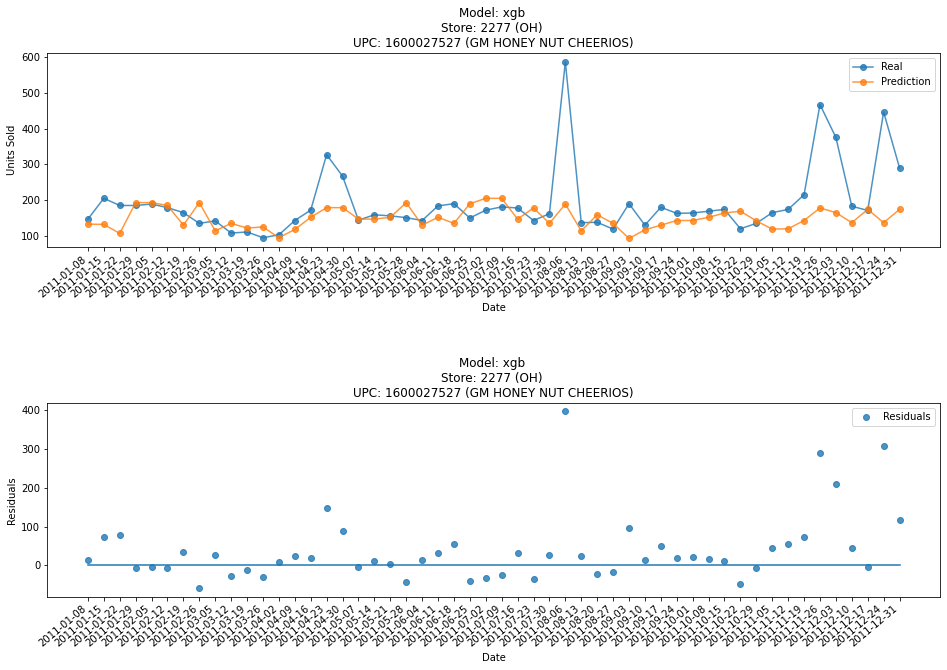

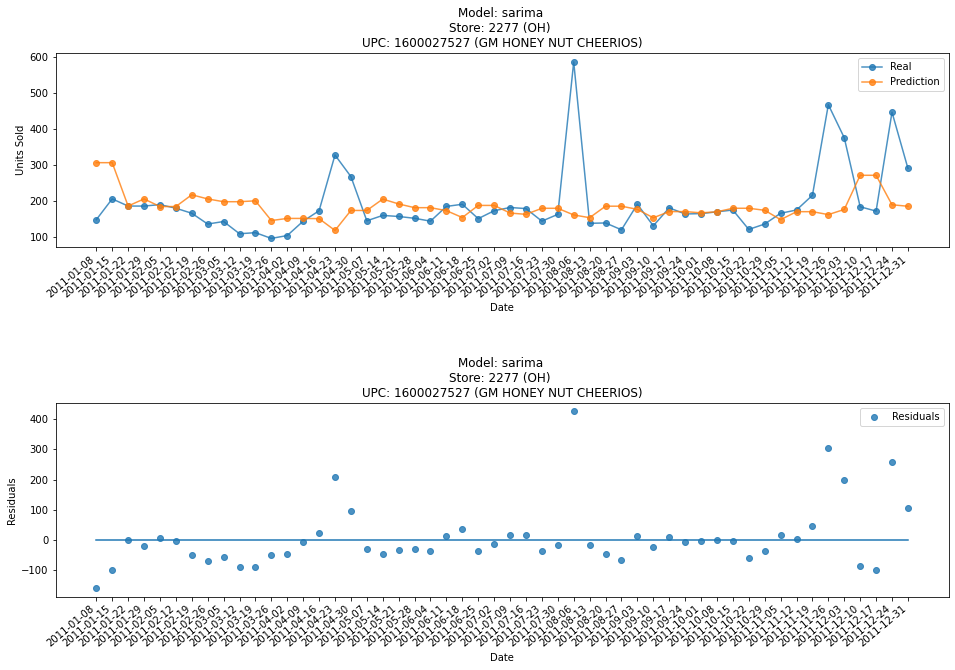

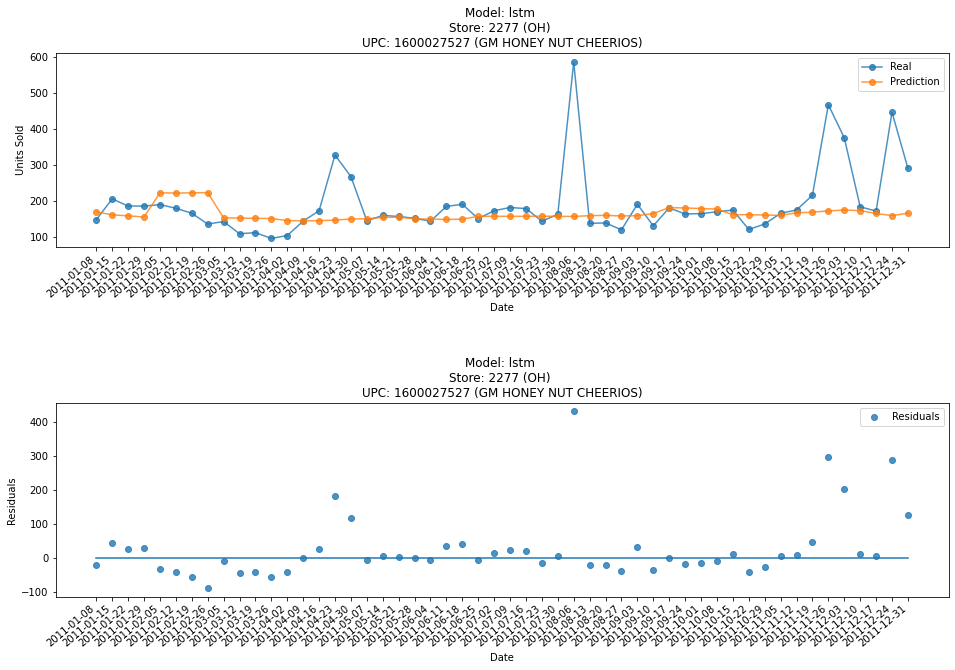

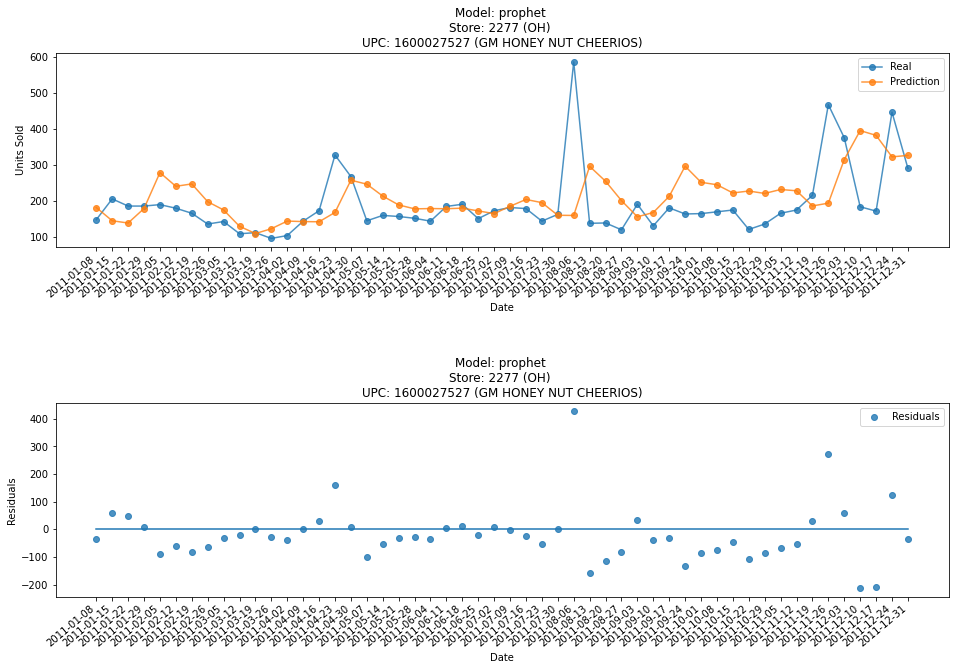

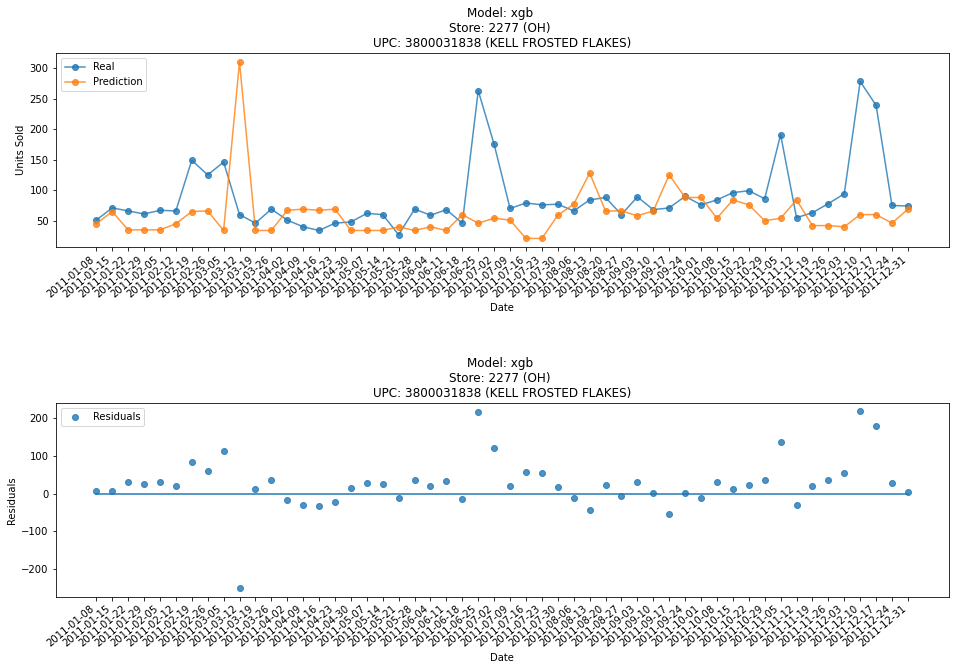

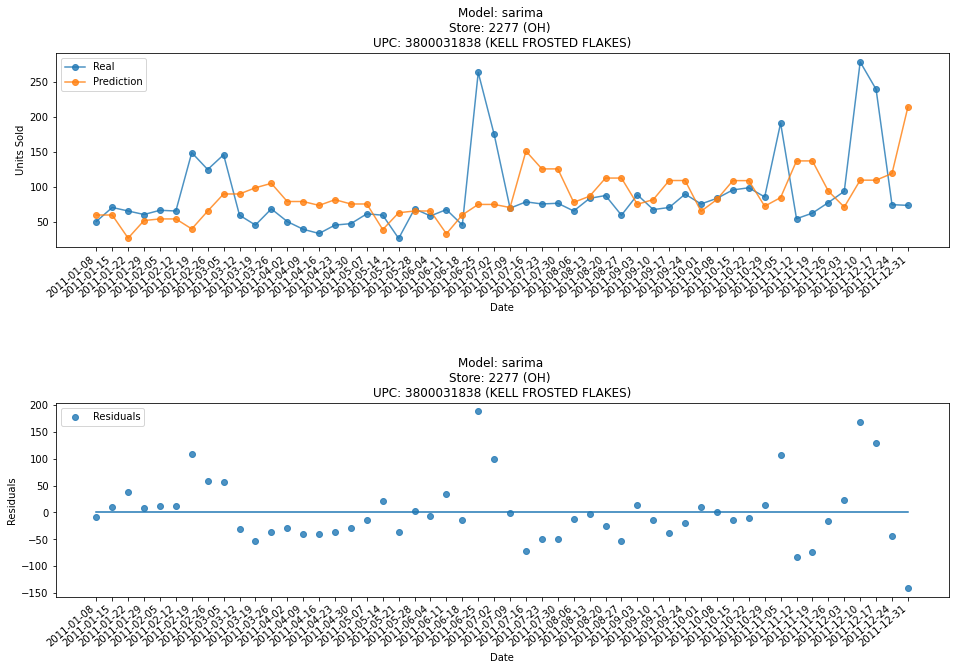

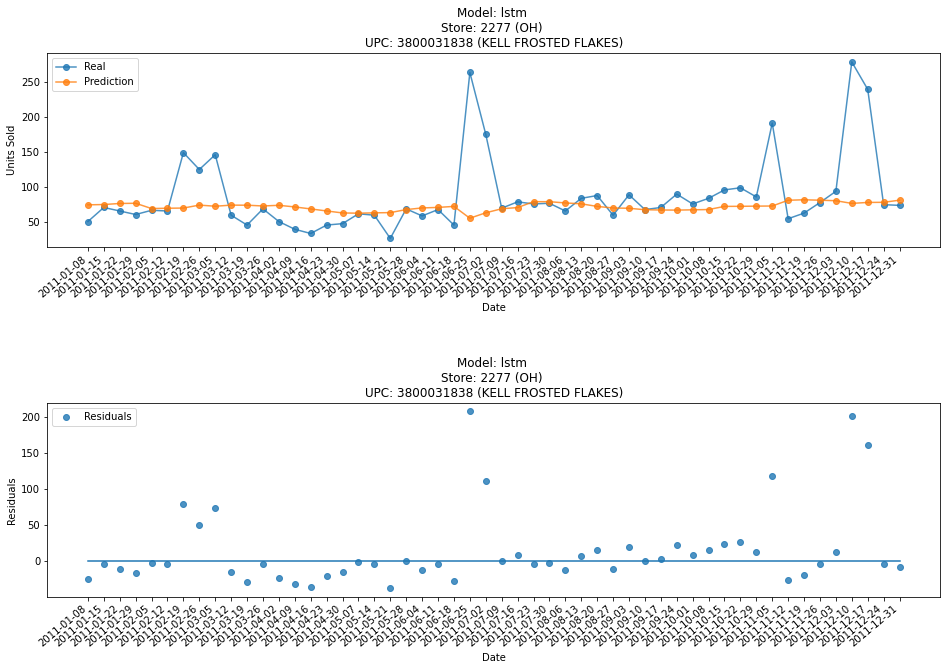

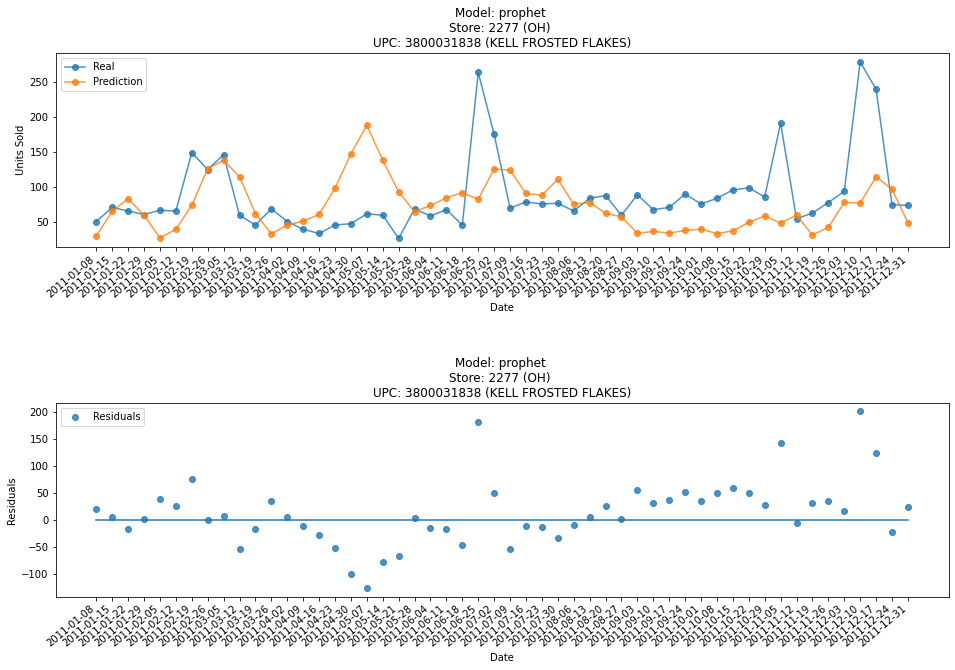

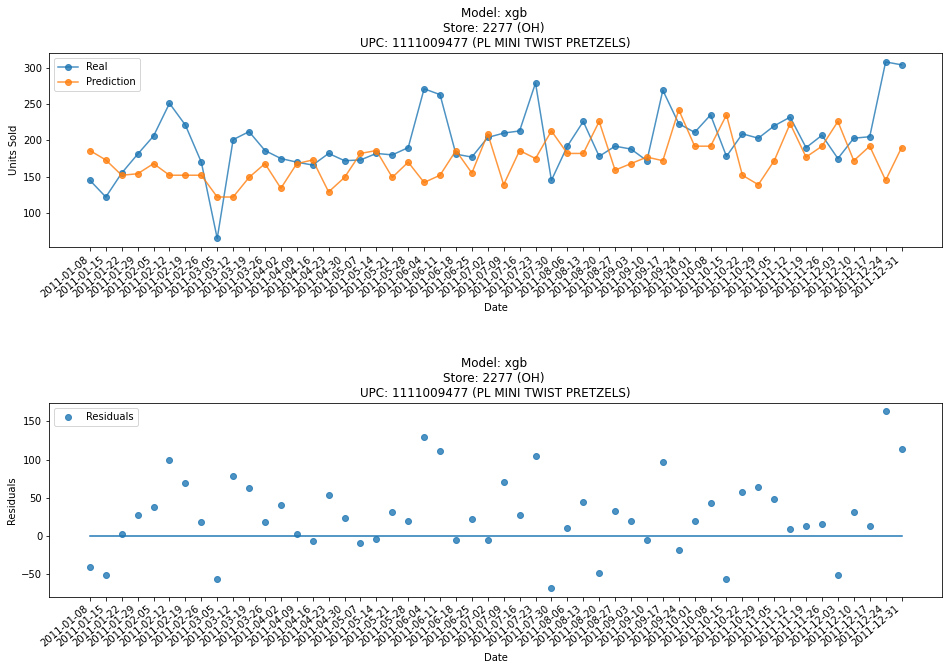

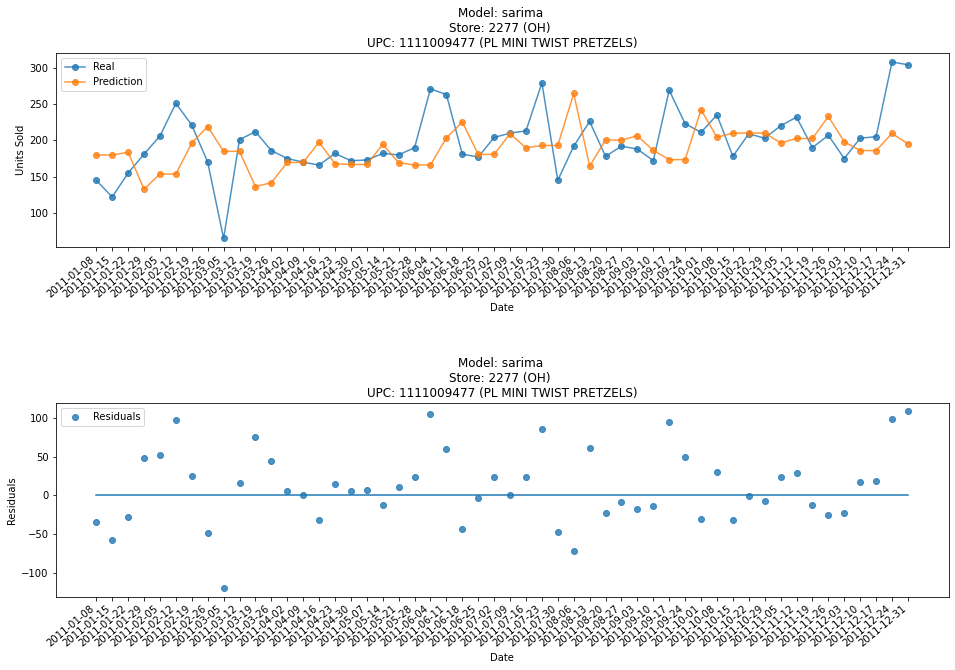

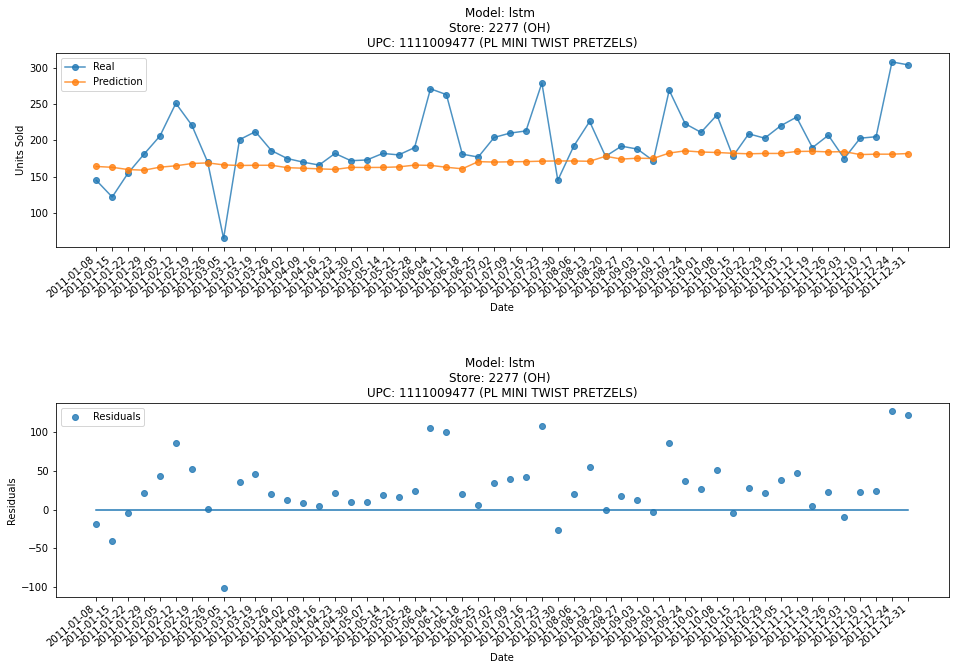

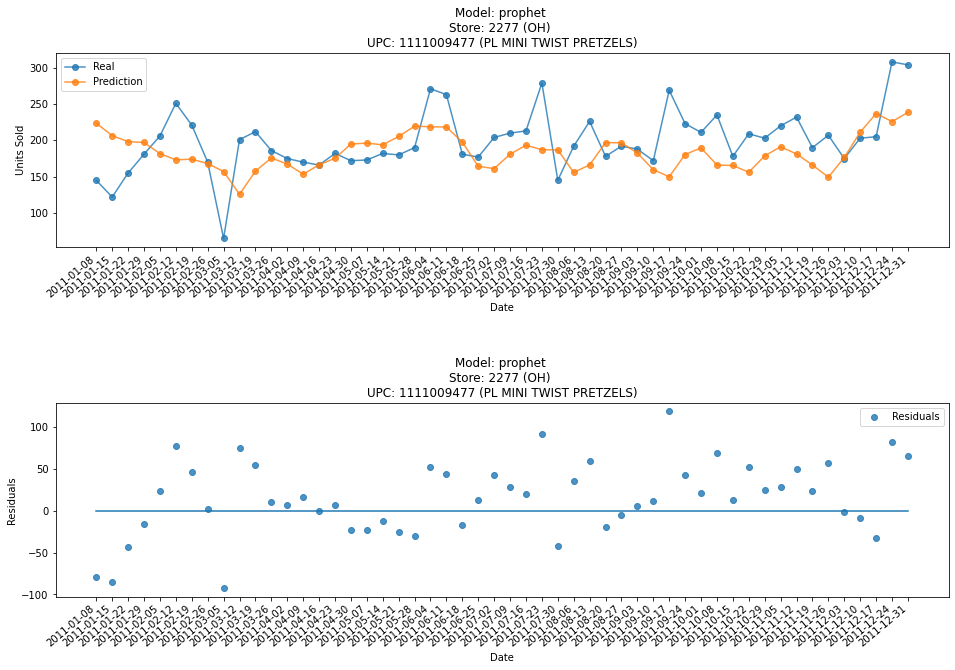

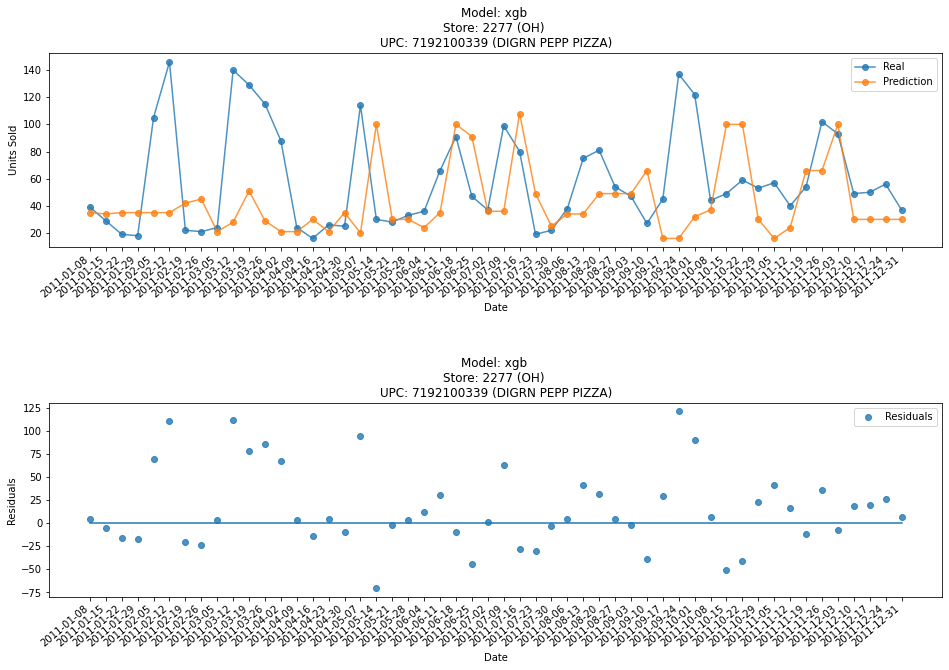

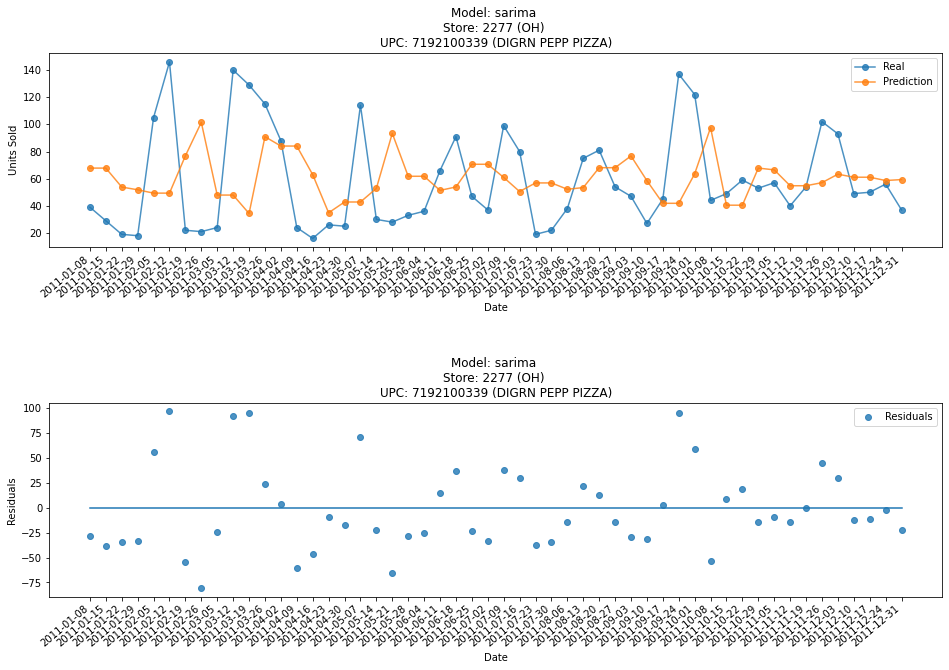

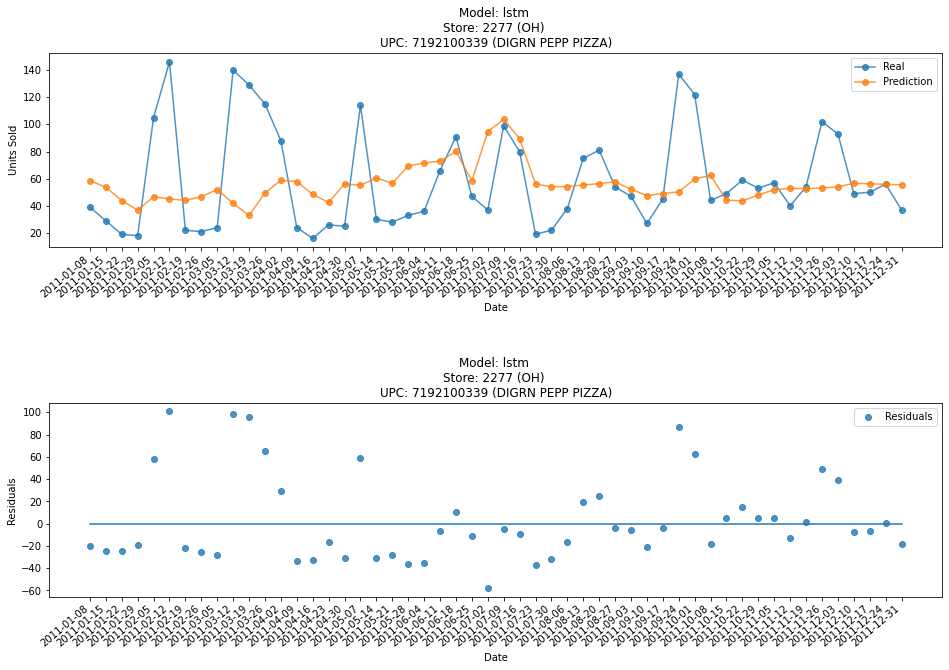

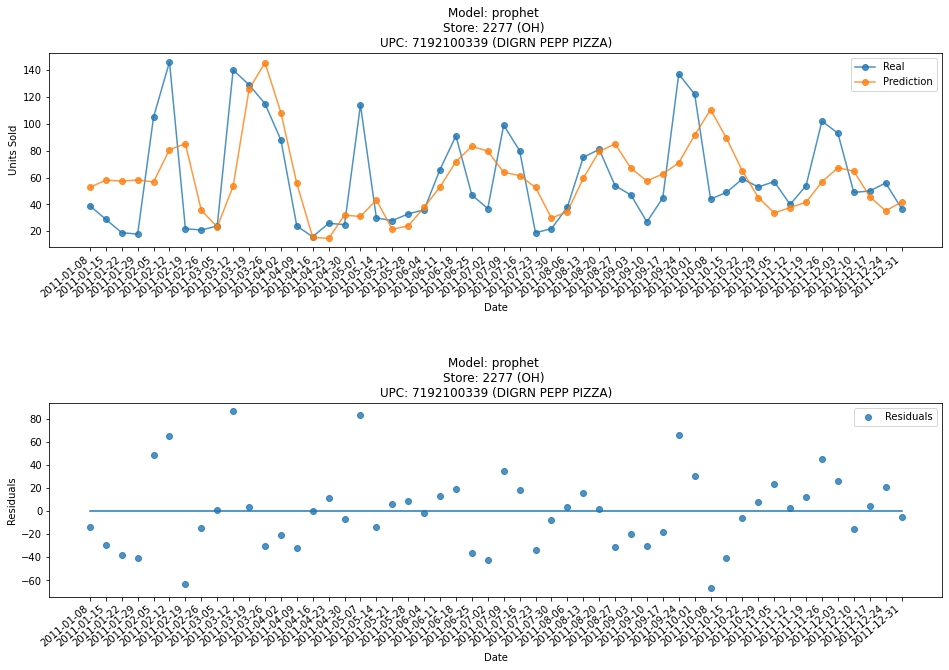

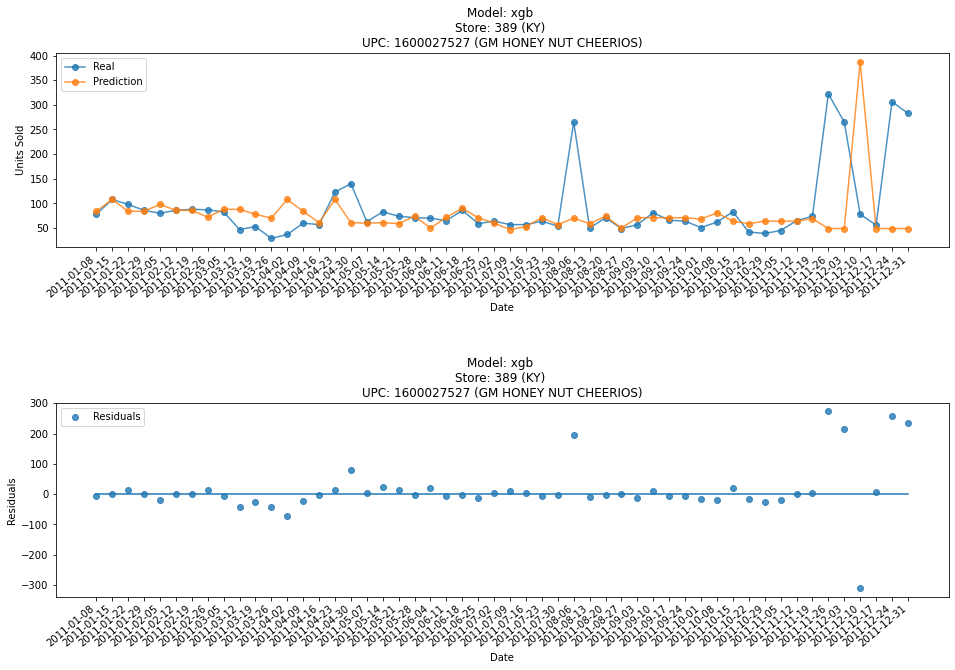

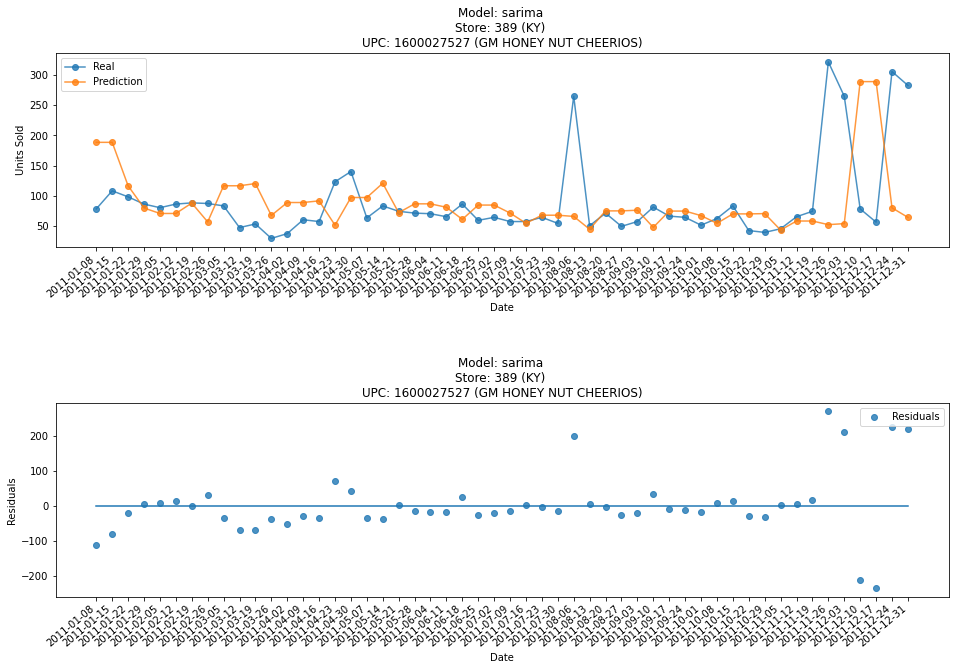

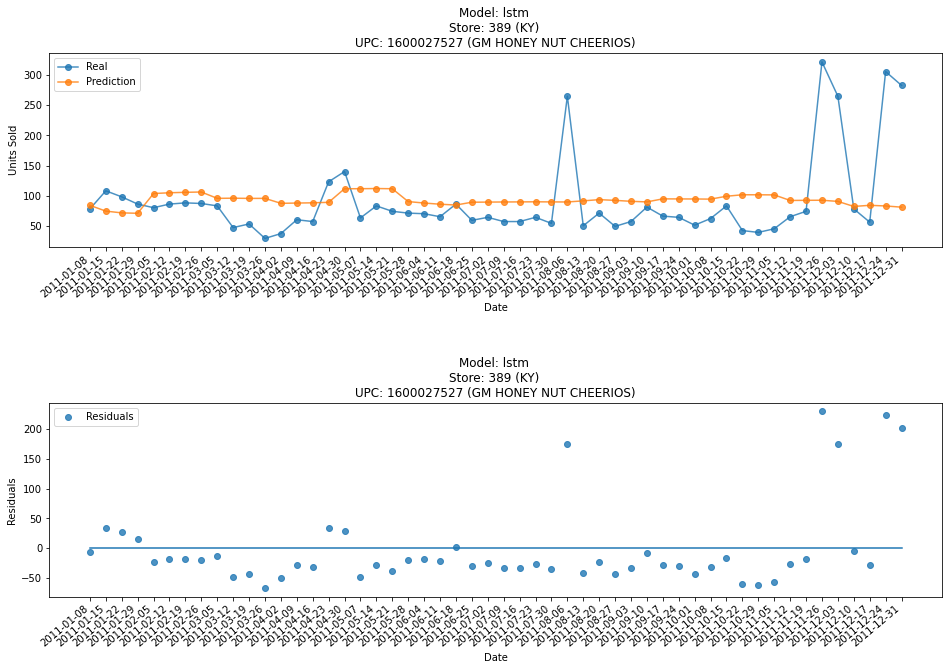

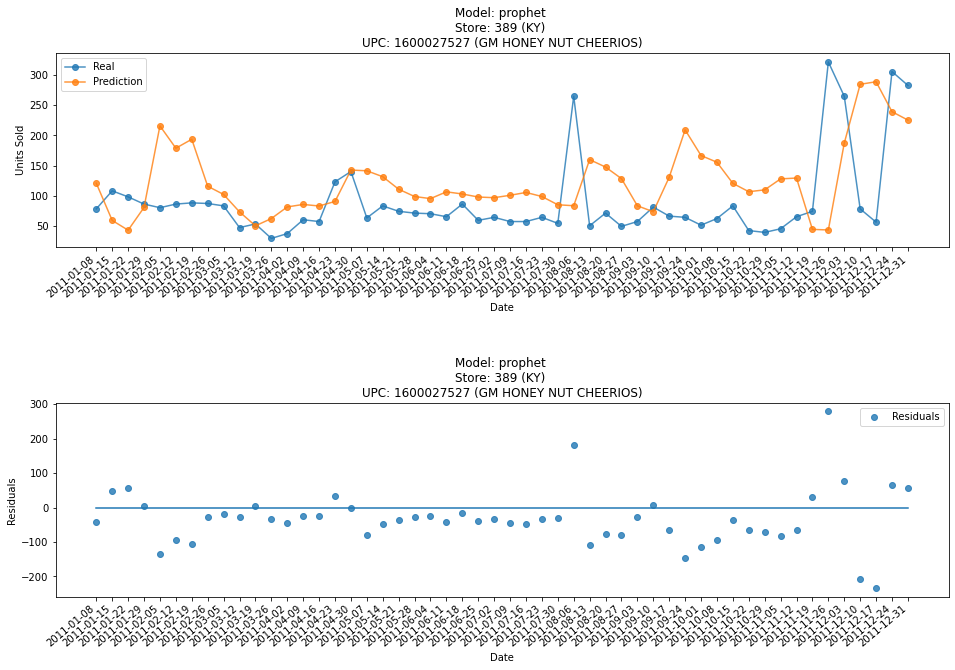

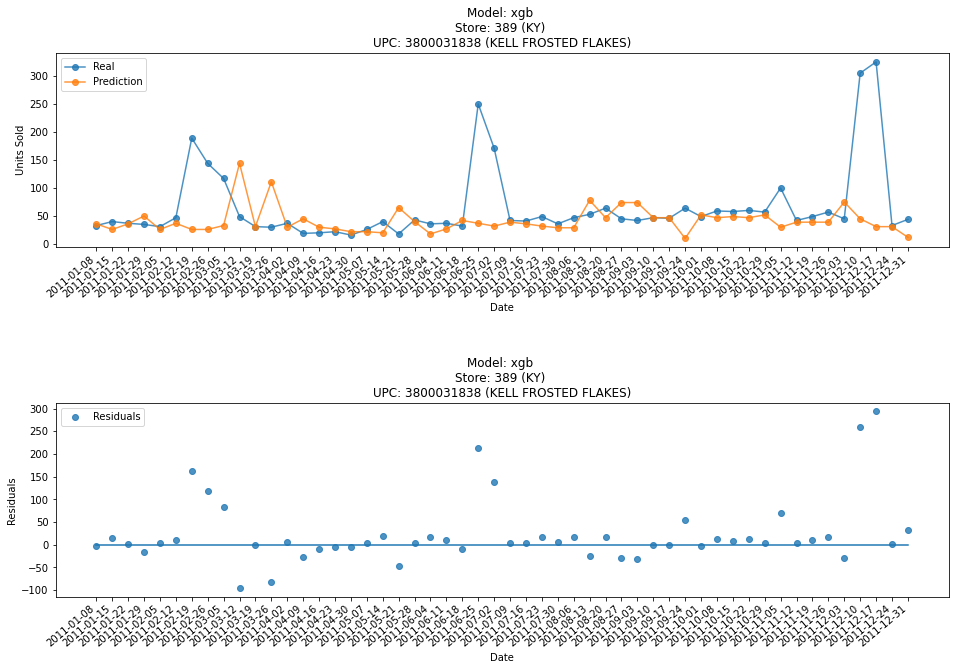

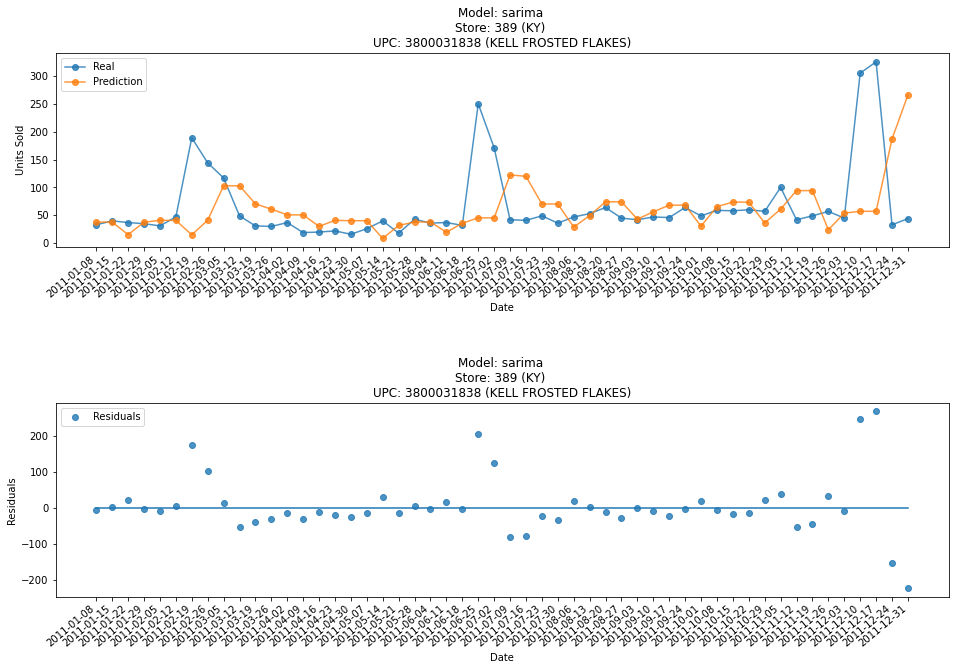

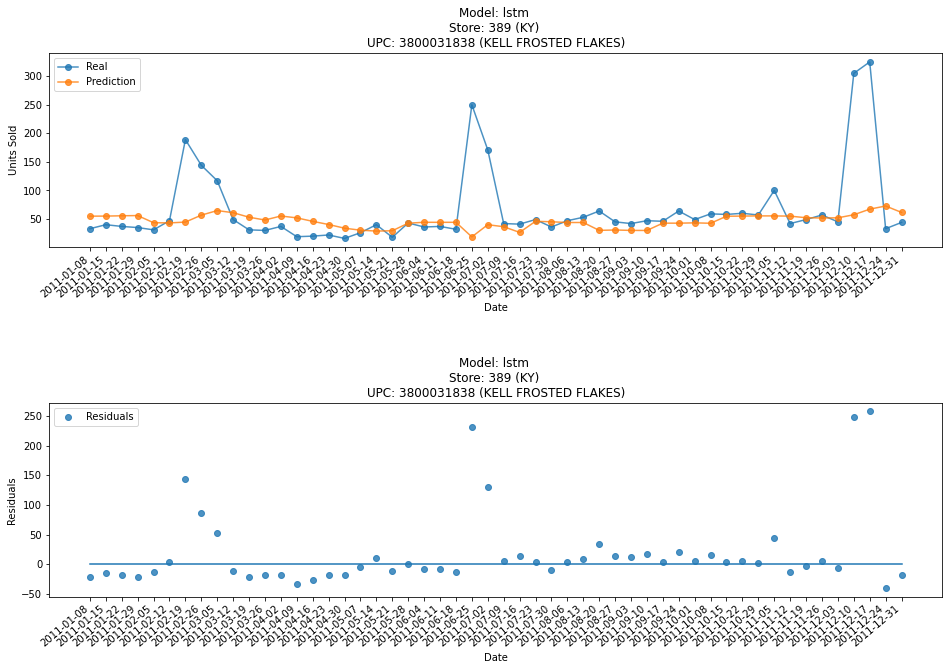

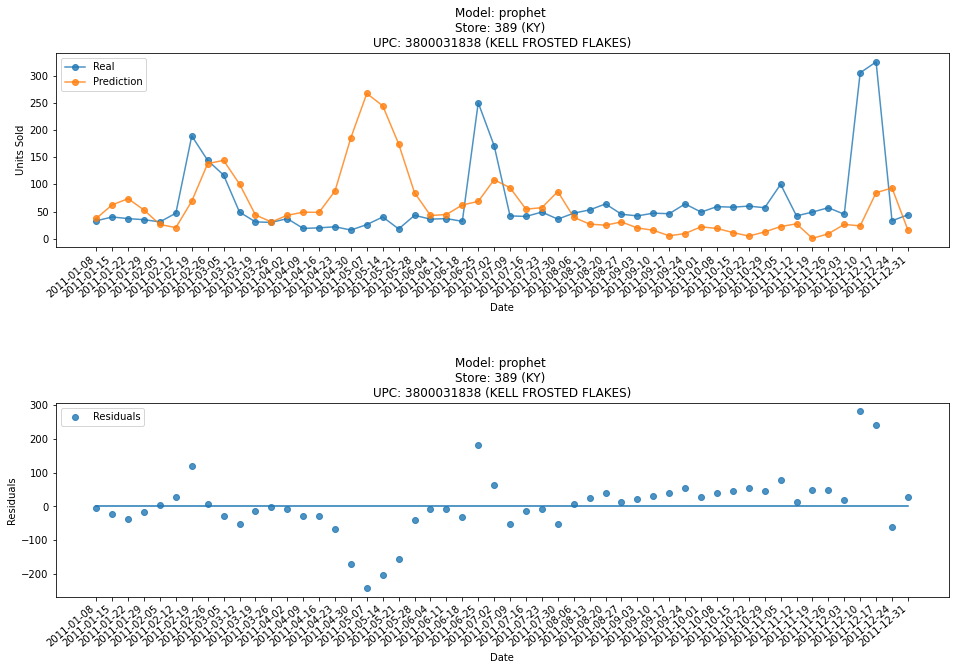

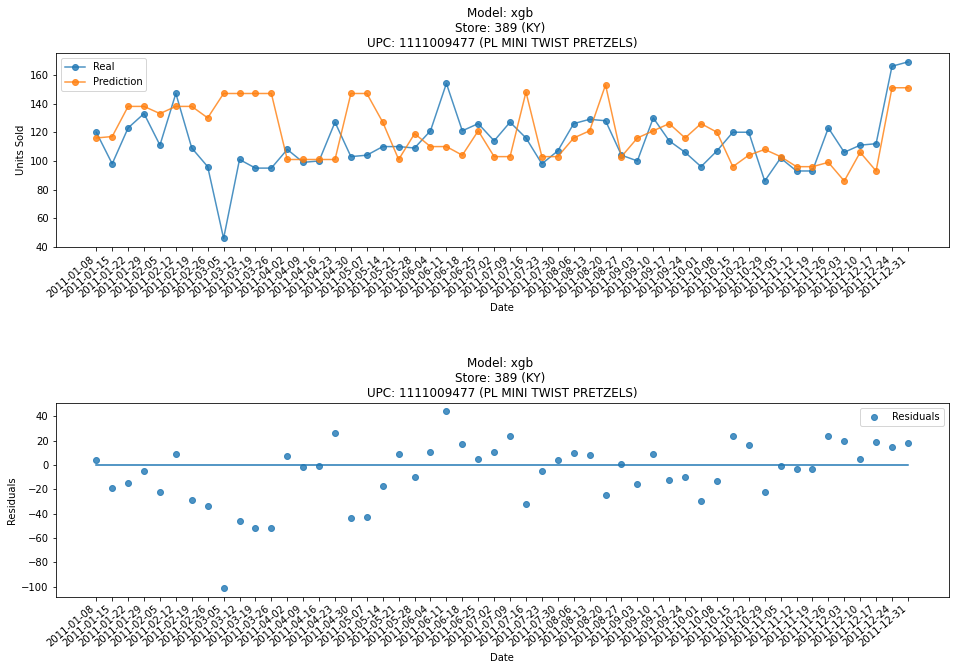

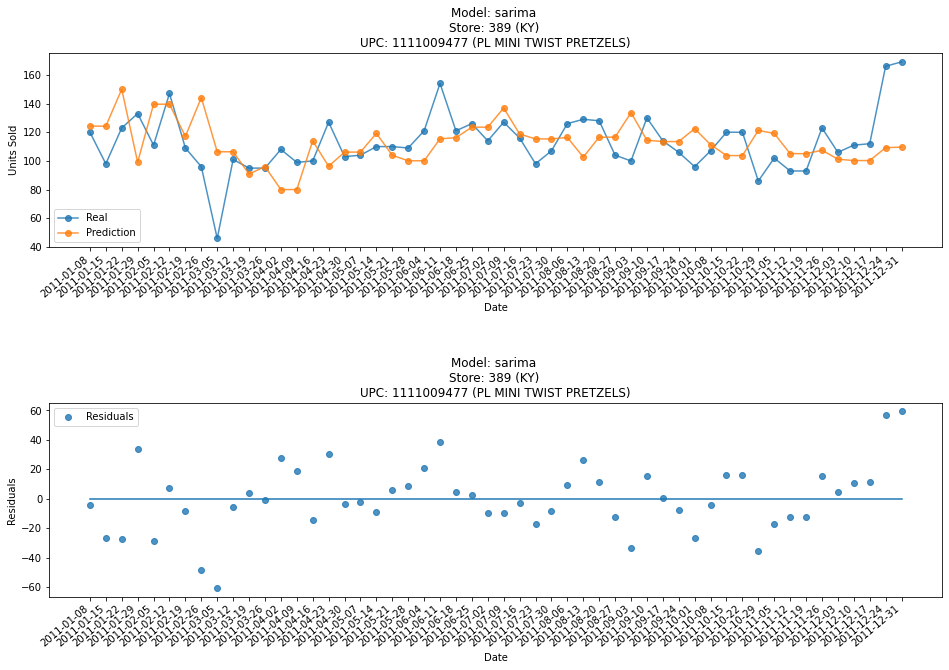

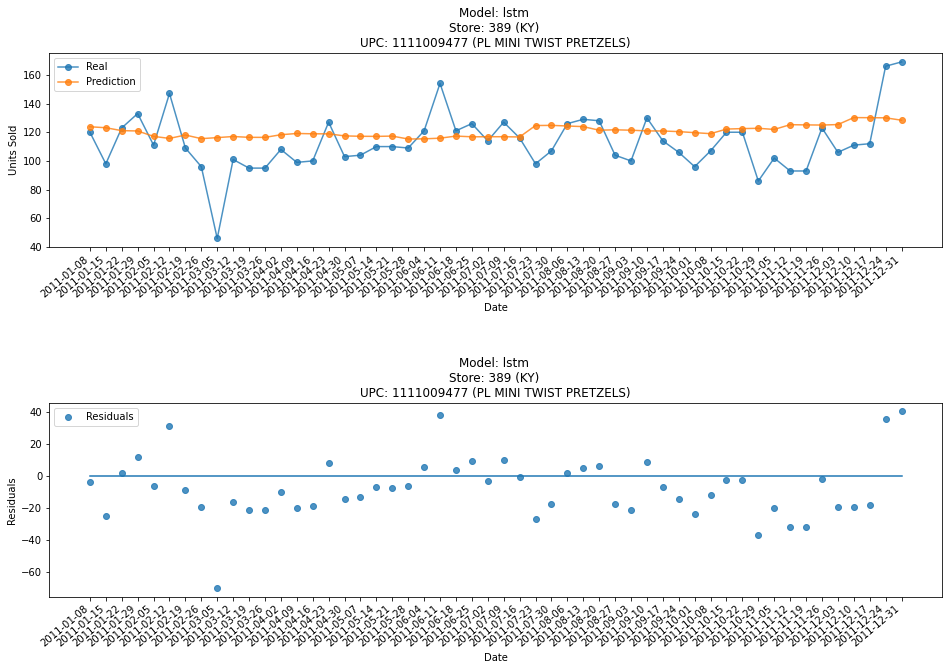

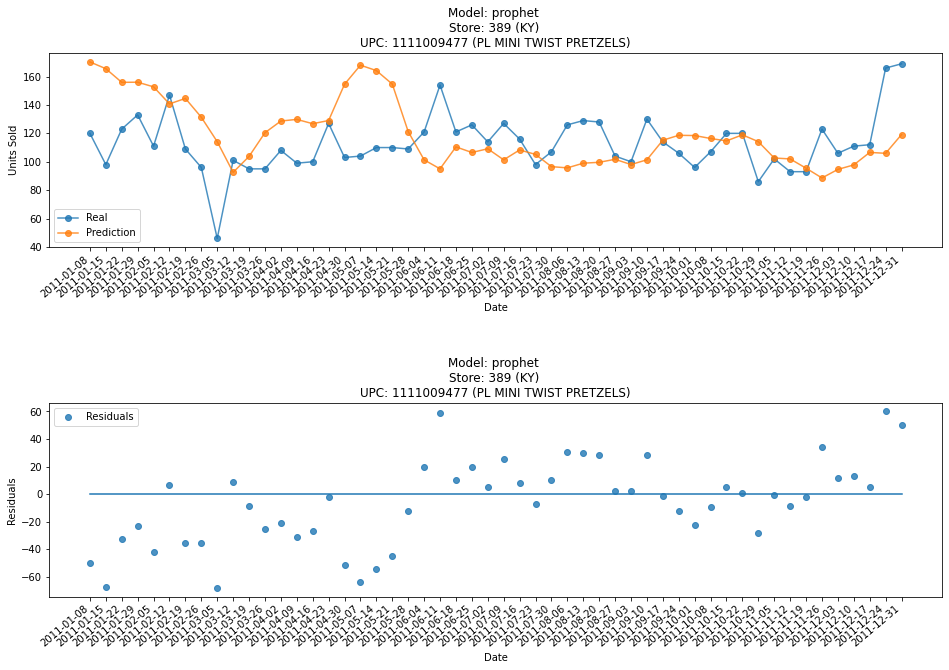

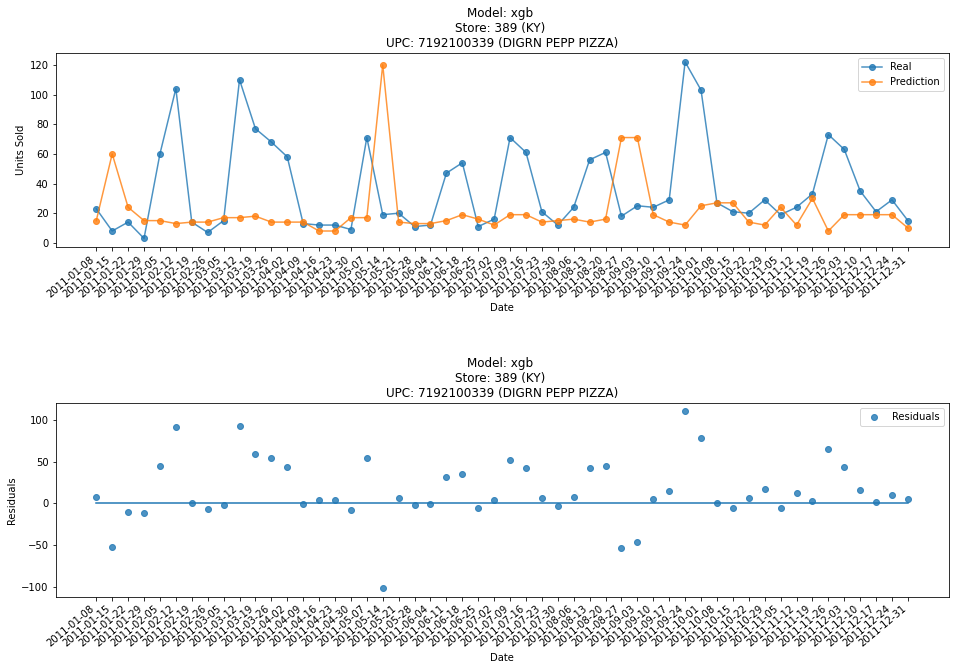

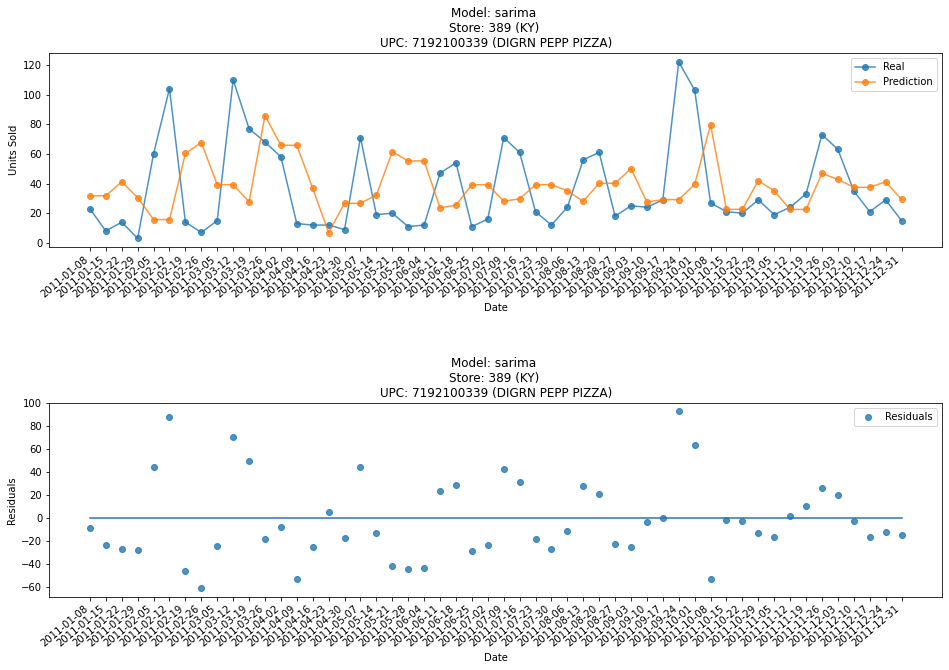

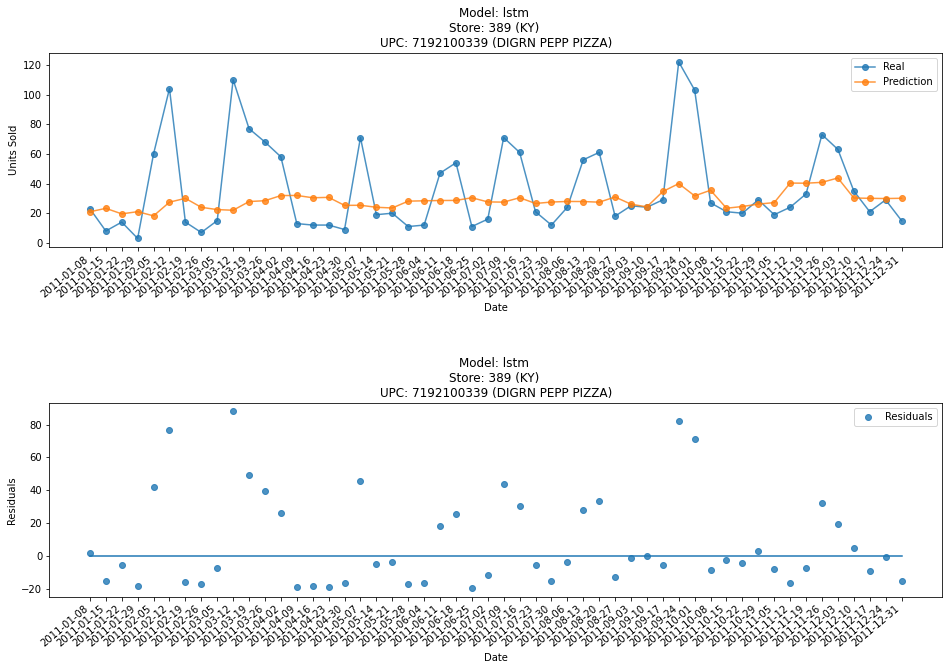

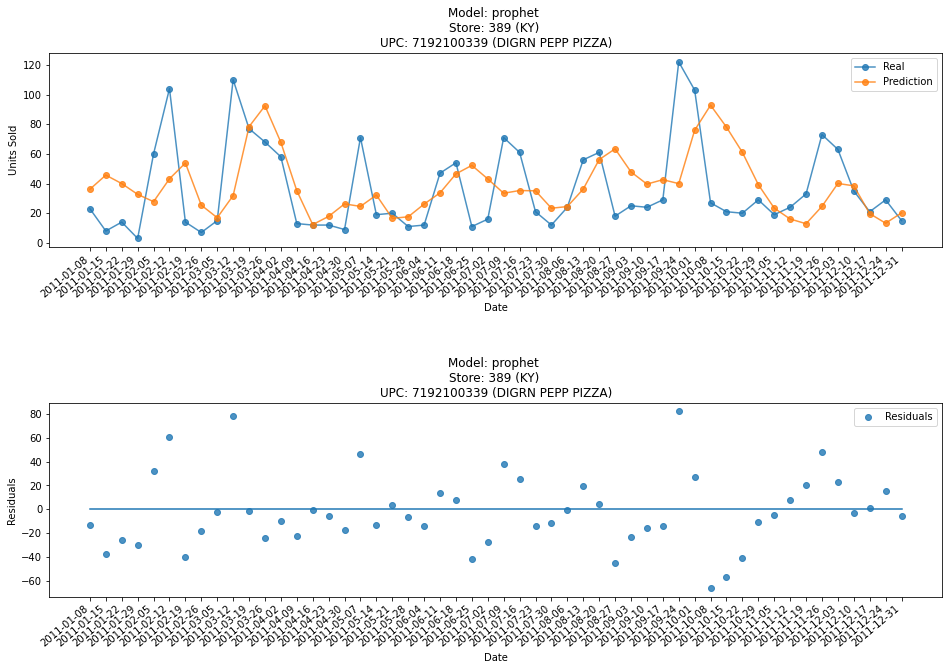

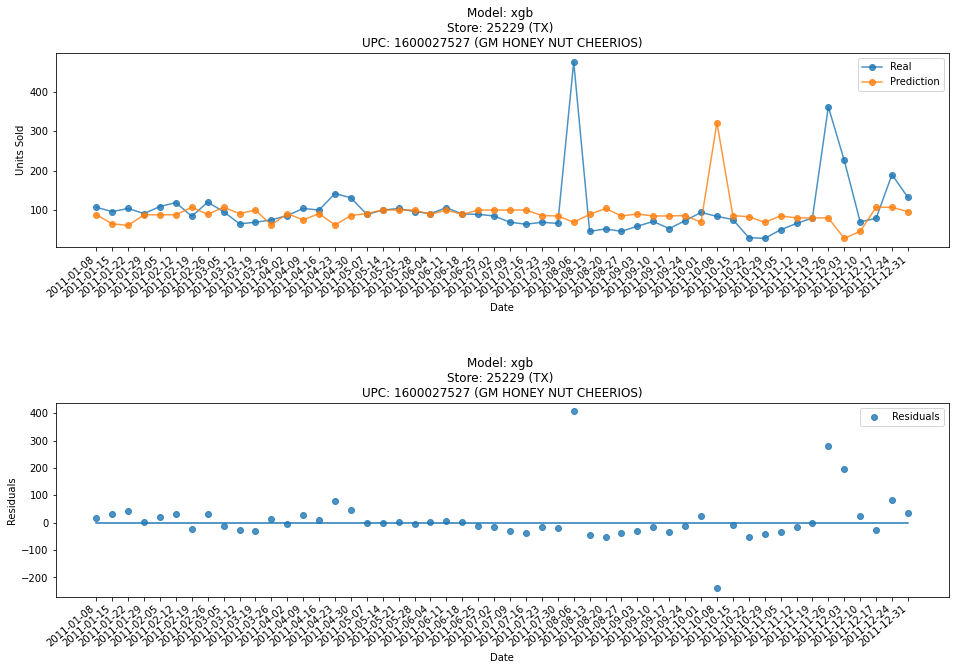

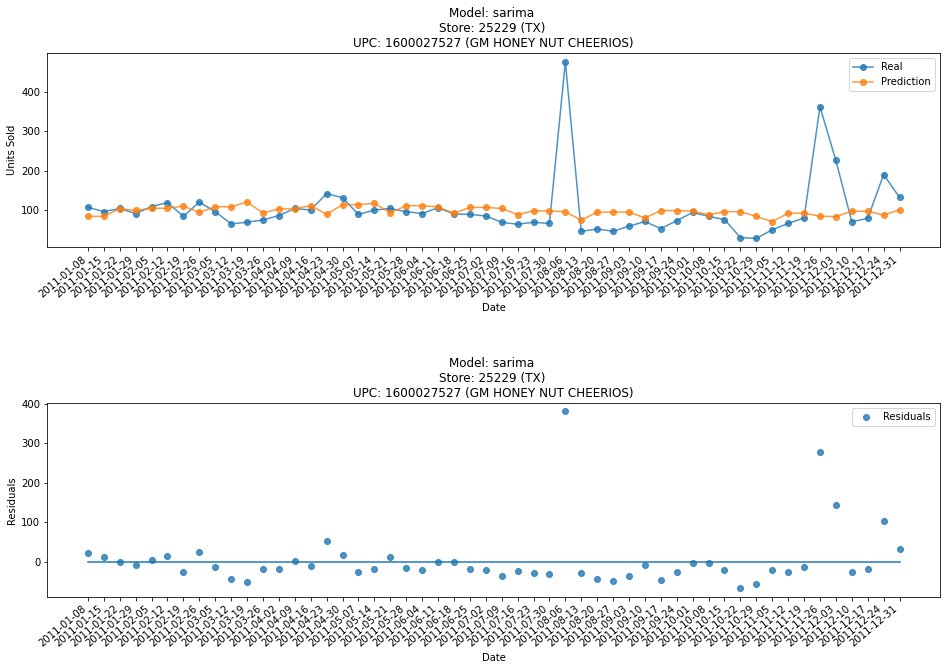

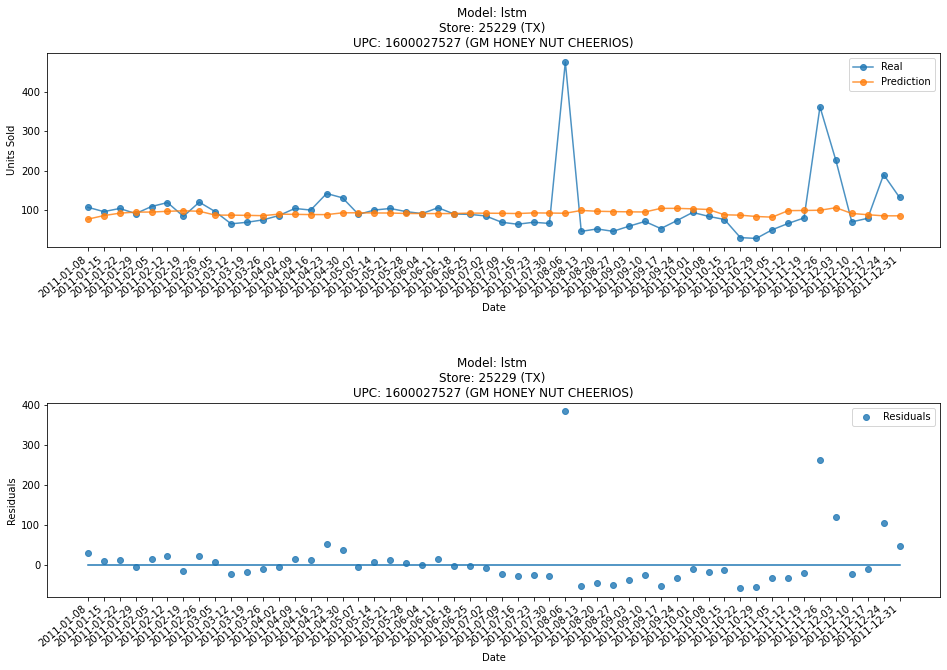

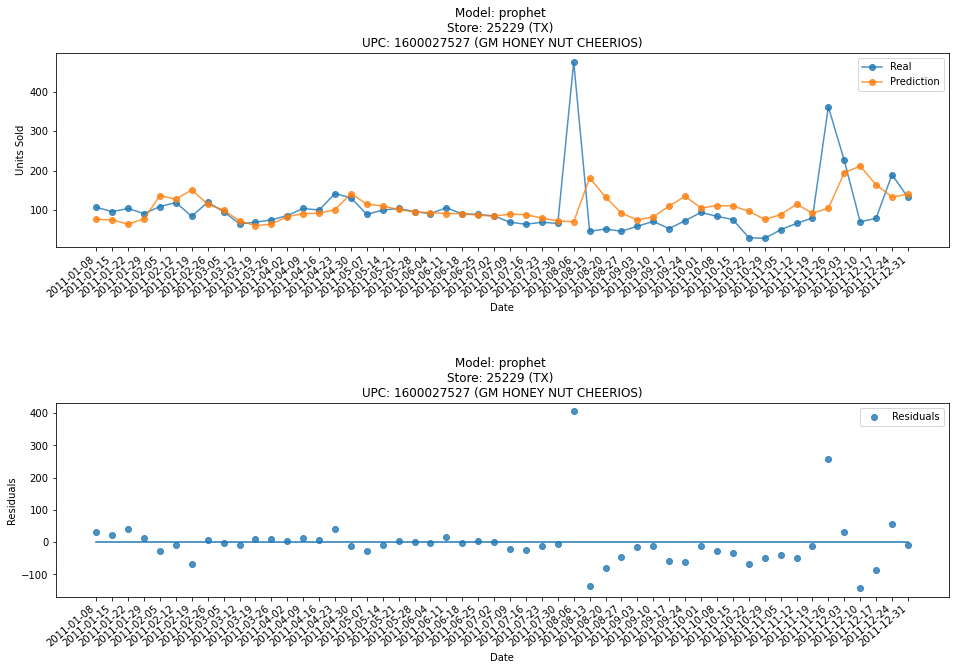

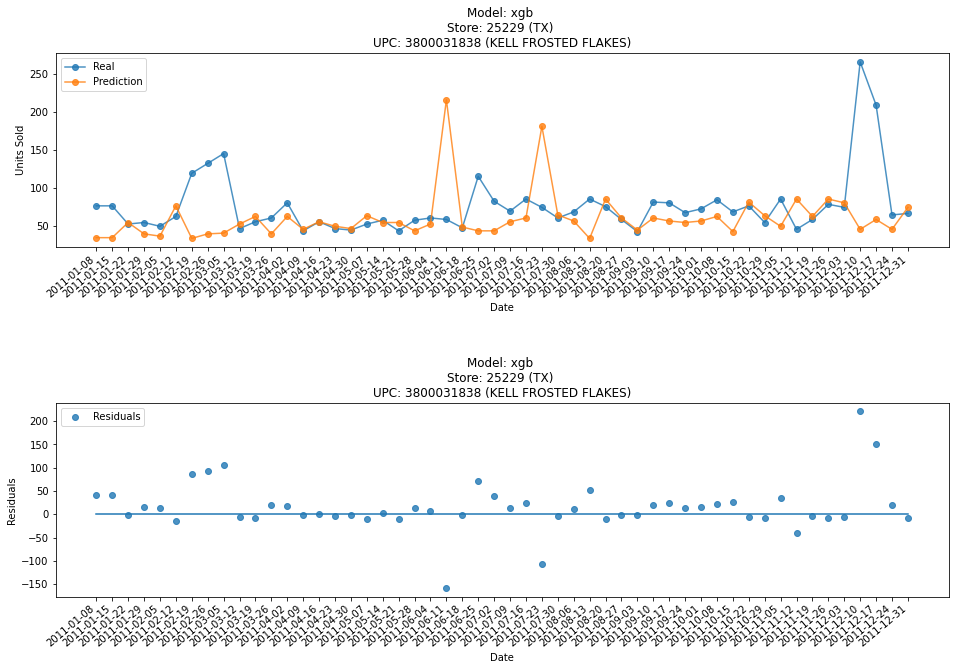

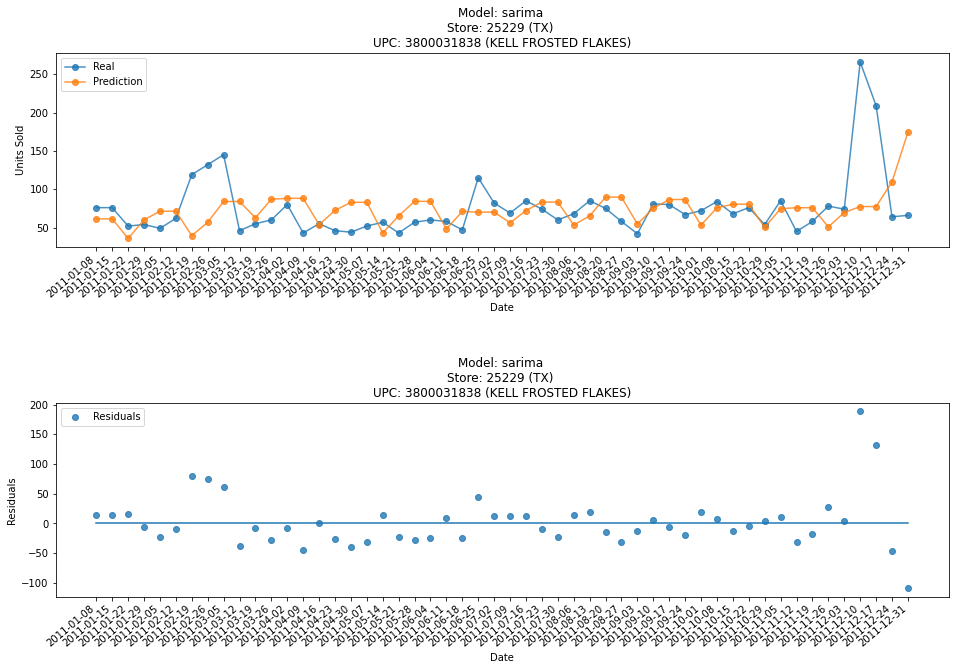

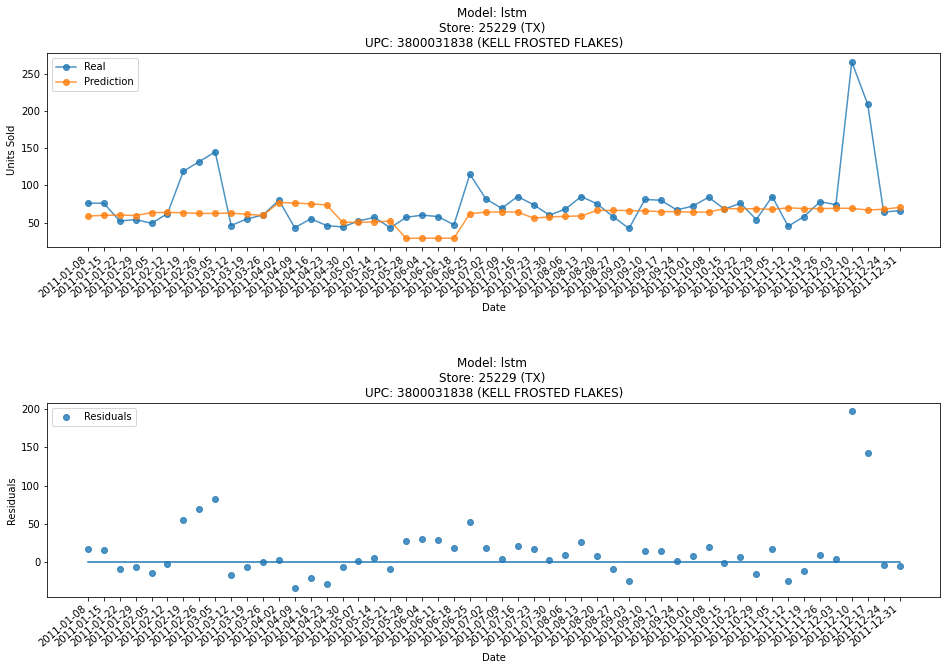

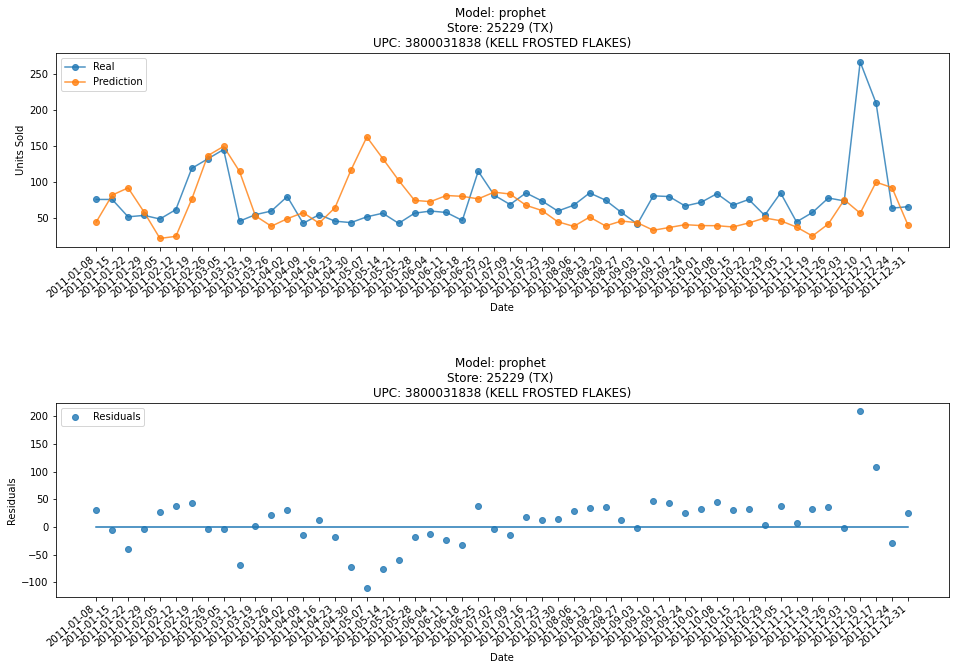

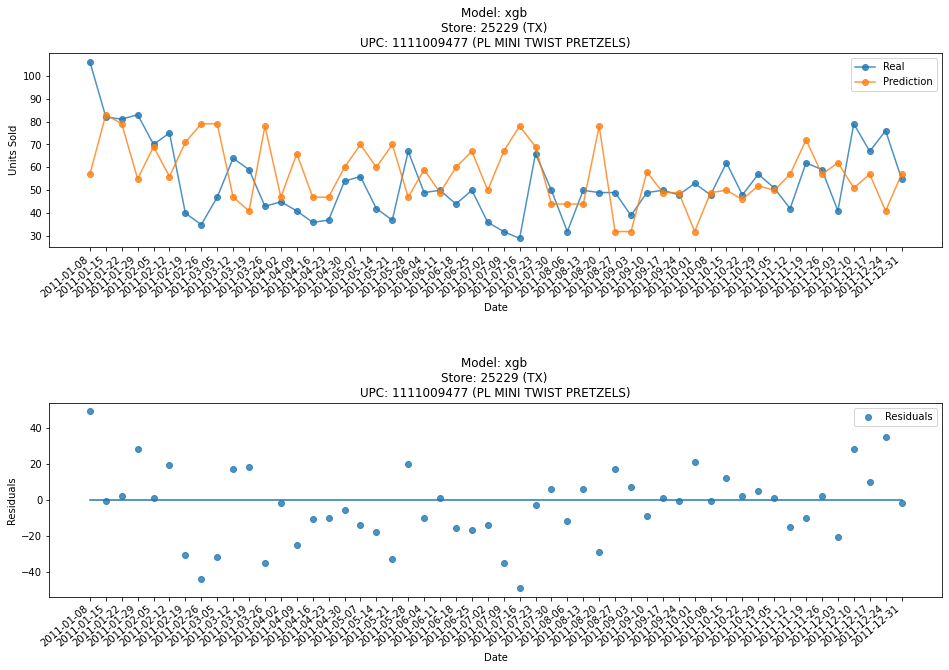

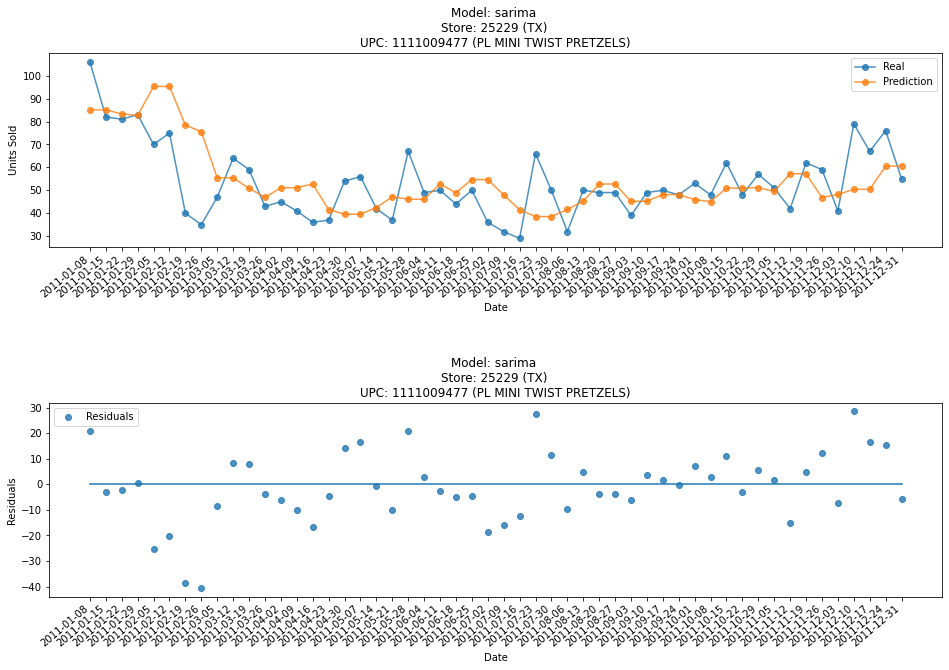

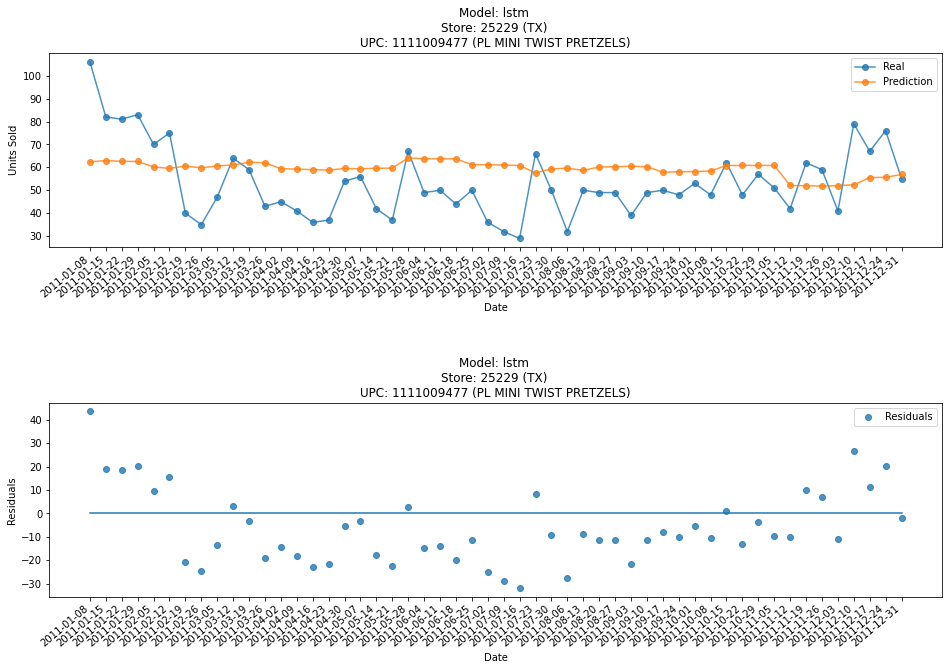

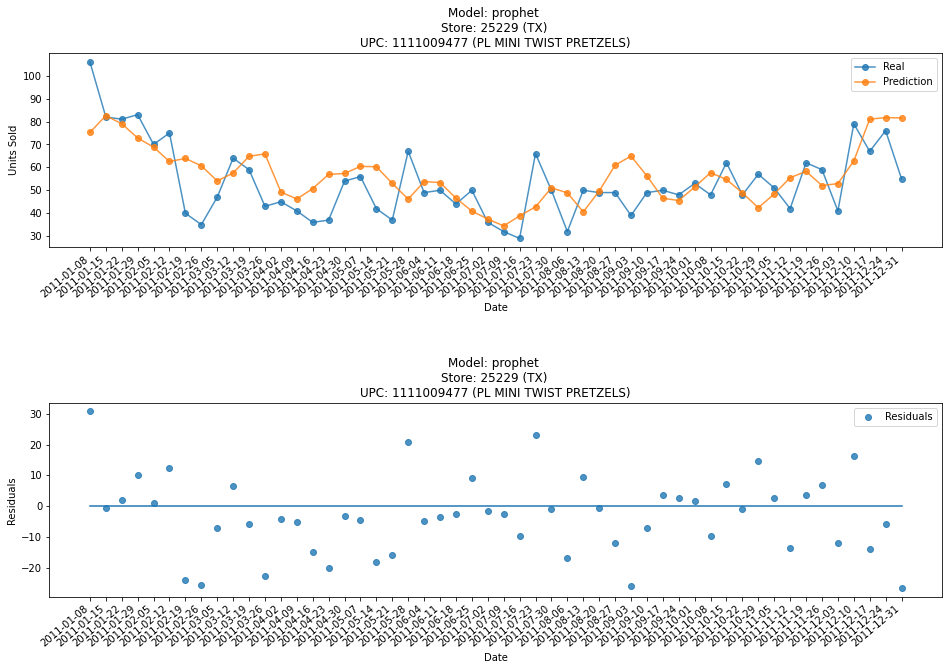

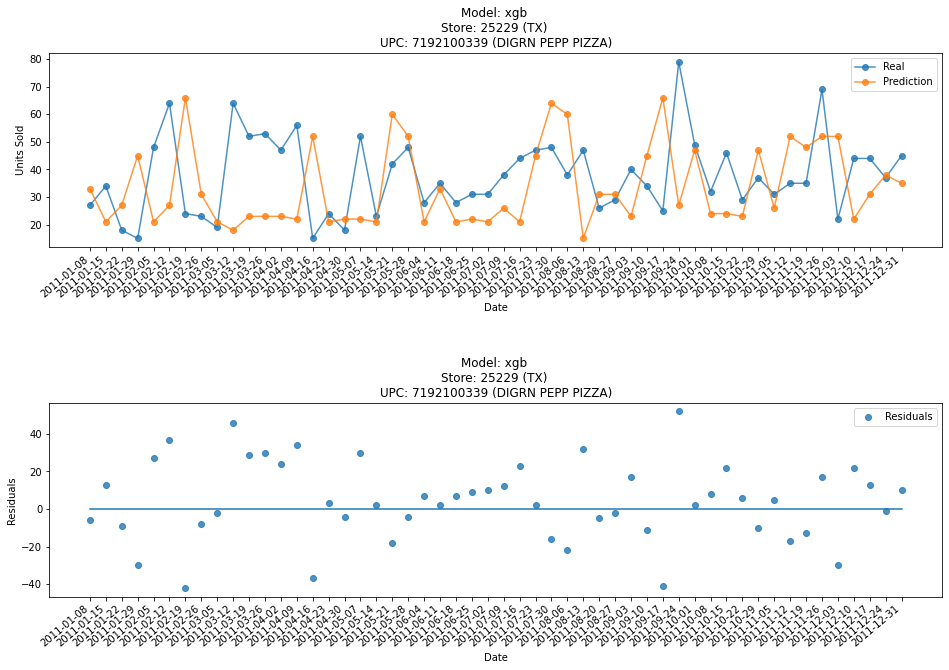

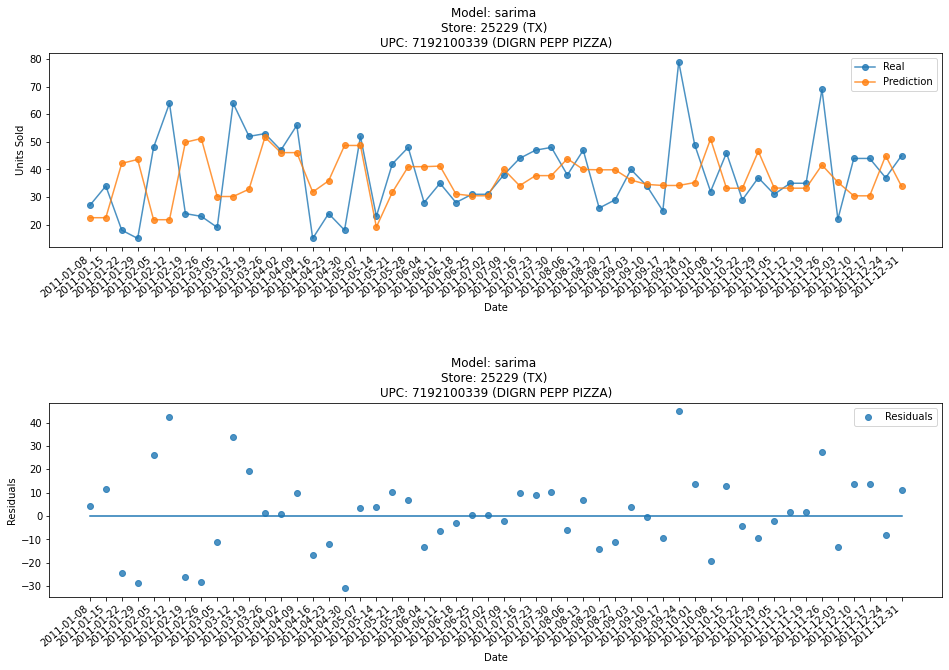

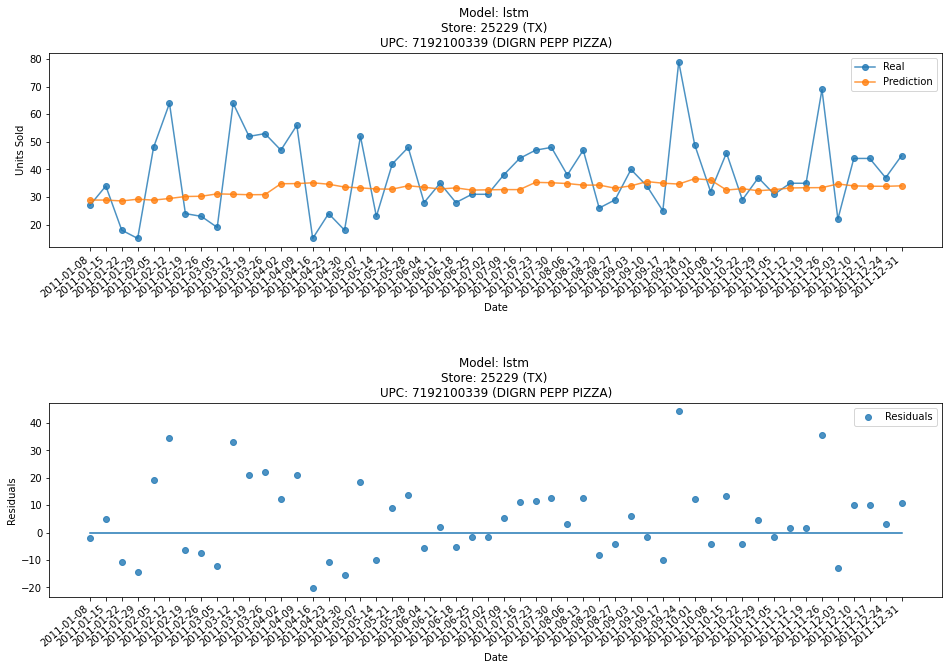

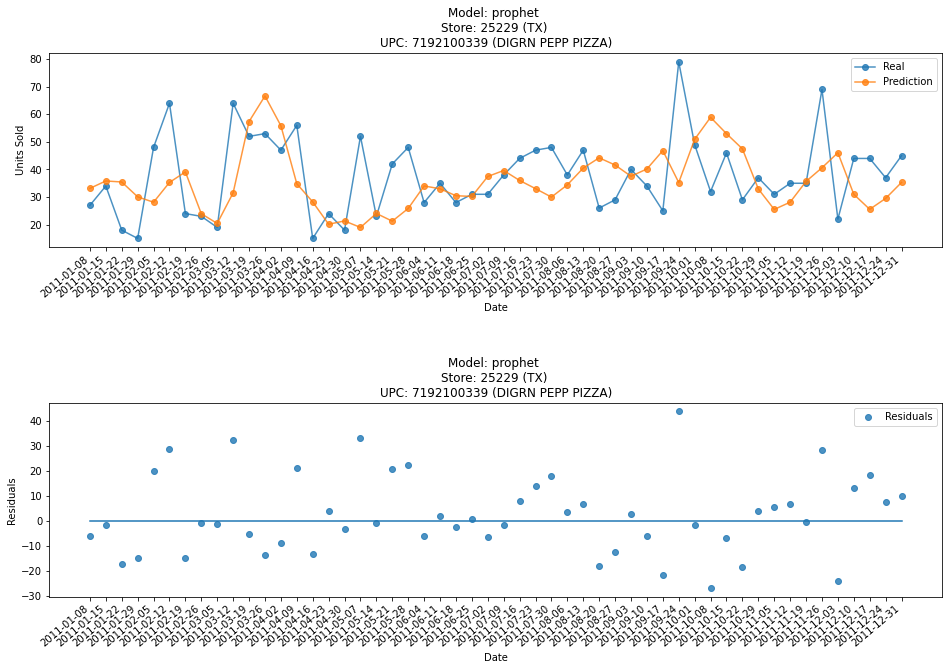

In [49]:
# Plot the forecast for each model

for store, upc in full_search:
    
    temp = all_stores_upc[f'{store}_{upc}']
    temp.sort_index(inplace=True)

    for model in ['xgb','sarima','lstm','prophet']:
        upc_name = lookup_products[lookup_products['UPC']==upc]['DESCRIPTION'].iloc[0]
        store_state = params['breakfast']['dataset']['store_ids'][store]
        
        fig, axs = plt.subplots(2, 1, figsize=(16,10))
        plt.subplots_adjust(hspace=0.8)
        
        # Forecasts
        axs[0].plot(temp['y_true'], marker='o', label='Real',alpha=0.8)
        axs[0].plot(temp[f'y_pred_{model}'], marker='o', label='Prediction',alpha=0.8)
        axs[0].set_title(f'Model: {model} \nStore: {store} ({store_state}) \nUPC: {upc} ({upc_name})')
        axs[0].set_xlabel('Date')
        axs[0].set_ylabel('Units Sold')
        axs[0].legend()
        for tick in axs[0].get_xticklabels():
            tick.set_rotation(40)
            tick.set_horizontalalignment('right')
            
        # Residuals
        axs[1].scatter(x=temp.index, y=(temp['y_true'] - temp[f'y_pred_{model}']), marker='o', label='Residuals', alpha=0.8)
        axs[1].plot([0]*temp.shape[0])
        axs[1].set_title(f'Model: {model} \nStore: {store} ({store_state}) \nUPC: {upc} ({upc_name})')
        axs[1].set_xlabel('Date')
        axs[1].set_ylabel('Residuals')
        axs[1].legend()
        for tick in axs[1].get_xticklabels():
            tick.set_rotation(40)
            tick.set_horizontalalignment('right')
        
        plt.show()
        
    print('\n\n\n')